# AIDL02 Final Task

## Fire-Smoke-NonFire Classification

Wildfires are a significant concern in Greece, burning thousands of hectares each year. According to [Statista](https://www.statista.com/statistics/1264709/area-burned-by-wildfire-in-greece/) "*in 2023, wildfires in Greece had burned an area of 174,800 hectares. This was the largest figure reported during the period in consideration, surpassing the previous record registered just two years earlier*". Note: 1 hectare = 10.000 square meters

<a href="https://www.statista.com/statistics/1264709/area-burned-by-wildfire-in-greece/" rel="nofollow"><img src="https://www.statista.com/graphic/1/1264709/area-burned-by-wildfire-in-greece.jpg" alt="Statistic: Area burned by wildfires in Greece from 2009 to 2023 (in hectares) | Statista" style="width: 100%; height: auto !important; max-width:1000px;-ms-interpolation-mode: bicubic;"/></a><br />Find more statistics at  <a href="https://www.statista.com" rel="nofollow">Statista</a>

Furthermore, as stated by [Global Forest Watch](https://www.globalforestwatch.org/dashboards/country/GRC/?category=fires&location=WyJjb3VudHJ5IiwiR1JDIl0%3D) "*From 2001 to 2023, Greece lost 194 thousand hectares (kha) of tree cover from fires and 99.6 kha from all other drivers of loss. The year with the most tree cover loss due to fires during this period was 2021 with 45.4 kha lost to fires — 93% of all tree cover loss for that year*." Also, the same source claims that "*fires were responsible for 66% of tree cover loss in Greece between 2001 and 2023.*"

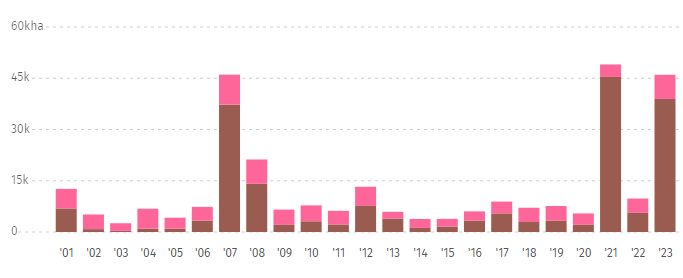

[source](https://gfw.global/44sGa6h)

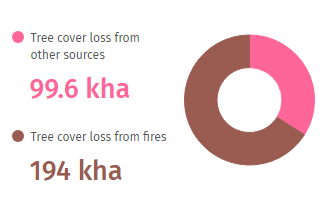

[source](https://gfw.global/3SbfORp)

Αs a result, early and accurate fire detection is crucial for minimizing damage and saving lives.  By developing an AI model that can effectively identify fire and smoke, can potentially contribute in aiding firefighters and fire prevention efforts.

### Download the dataset from Kaggle

In [ ]:
# Upload kaggle.json file
from google.colab import files
files.upload()

In [1]:
# Install Kaggle
%pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Note: you may need to restart the kernel to use updated packages.
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/home/miltech/.kaggle/kaggle.json': No such file or directory


In [2]:
# Download the dataset
!kaggle datasets download -d amerzishminha/forest-fire-smoke-and-non-fire-image-dataset

# Unzip the dataset
import zipfile
import os

with zipfile.ZipFile('forest-fire-smoke-and-non-fire-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('forest_fire_images')
os.listdir('forest_fire_images')

Dataset URL: https://www.kaggle.com/datasets/amerzishminha/forest-fire-smoke-and-non-fire-image-dataset
License(s): CC0-1.0
100%|██████████████████████████████████████| 6.43G/6.43G [39:45<00:00, 3.18MB/s]
100%|██████████████████████████████████████| 6.43G/6.43G [39:45<00:00, 2.89MB/s]


['FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET']

### Imports

In [ ]:
%pip install pip install tensorflow[and-cuda]==2.15.*
%pip install matplotlib numpy opencv-python scikit-learn seaborn pandas

In [21]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
import seaborn as sns
import pandas as pd

In [2]:
# Check TensorFlow version
print(tf.__version__)

2.15.1


In [3]:
# Check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Check if TensorFlow is using GPU
print("TensorFlow GPU:", tf.test.is_built_with_cuda())

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow GPU: True


2024-07-15 14:08:17.031756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 14:08:17.064608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 14:08:17.066534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Data Loading & Exploration

While trying to evaluate the model on the test set, I got the following error: `Unknown image file format. One of JPEG, PNG, GIF, BMP required`. Thus I used the following script to identify those images and delete them. I borrowed it from the this StackOverflow [question](https://stackoverflow.com/questions/65438156/tensorflow-keras-error-unknown-image-file-format-one-of-jpeg-png-gif-bmp-re). I also added a function to delete the unsupported image types.

In [7]:
def check_images(s_dir, ext_list):
    bad_images = []
    bad_ext = []
    s_list = os.listdir(s_dir)
    for class_name in s_list:
        class_name_path = os.path.join(s_dir, class_name)
        print('processing class directory', class_name)
        if os.path.isdir(class_name_path):
            file_list = os.listdir(class_name_path)
            for f in file_list:
                f_path = os.path.join(class_name_path, f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                    bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img = cv2.imread(f_path)
                        shape = img.shape
                    except:
                        print('file', f_path, 'is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you have a subdirectory', f, 'in class directory', class_name)
        else:
            print('*** WARNING*** you have files in', s_dir, 'it should only contain subdirectories')
    return bad_images, bad_ext

def delete_bad_images(bad_images):
    for image in bad_images:
        try:
            os.remove(image)
            print(f'Deleted: {image}')
        except Exception as e:
            print(f'Error deleting {image}: {e}')

source_dir = "../content/forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test"
good_exts = ['jpg', 'png', 'jpeg', 'gif', 'bmp']  # list of acceptable extensions by TensorFlow
bad_file_list, bad_ext_list = check_images(source_dir, good_exts)

if len(bad_file_list) != 0:
    print('improper image files are listed below:')
    for bad_file in bad_file_list:
        print(bad_file)
    delete_bad_images(bad_file_list)
else:
    print('no improper image files were found')

processing class directory Smoke
processing class directory non fire
processing class directory fire


libpng warning: iCCP: known incorrect sRGB profile


improper image files are listed below:
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (174).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (128).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (239).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (593).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (187).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (746).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (319).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (959).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (159).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (1026).tif
forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/Smoke/Smoke (1050).tif
forest_fire_images/FORES

In [4]:
# Load dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "../content/forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/train"
test_dir = "../content/forest_fire_images/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test"

batch_size = 32 #32
img_size = (224, 224)
seed = 42

# Load training and validation datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=["fire", "non fire", "Smoke"],
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

validation_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=["fire", "non fire", "Smoke"],
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Load test dataset
test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    class_names=["fire", "non fire", "Smoke"],
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 31708 files belonging to 3 classes.
Using 25367 files for training.


2024-07-15 14:08:22.860286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 14:08:22.862308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 14:08:22.864147: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 31708 files belonging to 3 classes.
Using 6341 files for validation.
Found 9407 files belonging to 3 classes.


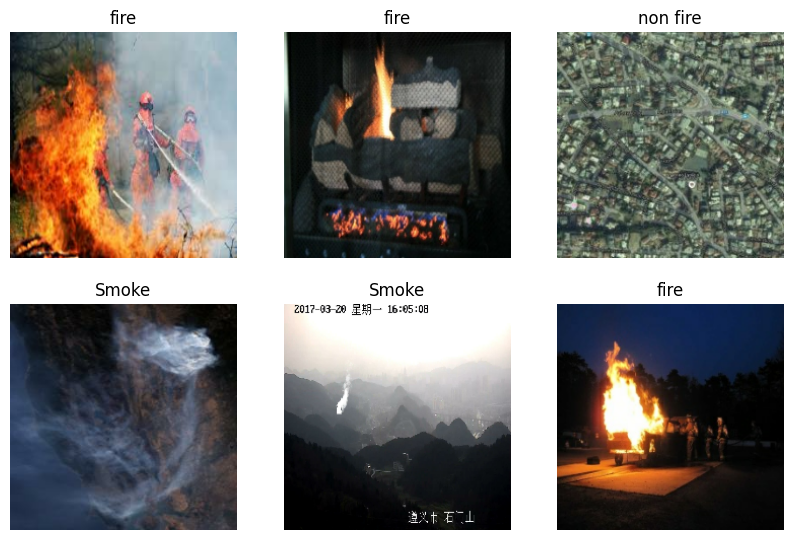

In [21]:
def plot_images_from_dataset(dataset, class_names, num_images=6):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        labels = tf.argmax(labels, axis=1)  
        num_images = min(num_images, len(images))
        for i in range(num_images):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off")

plot_images_from_dataset(train_dataset, ["fire", "non fire", "Smoke"])

In [5]:
def plot_class_distribution(dataset_dir, subset_name):
    '''Plot the class distribution of the dataset'''
    class_count = {}
    for class_name in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, class_name)
        num_images = len(os.listdir(class_dir))
        class_count[class_name] = num_images
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_count.keys(), class_count.values())
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title("Class distribution" + " " + subset_name) 
    plt.show()

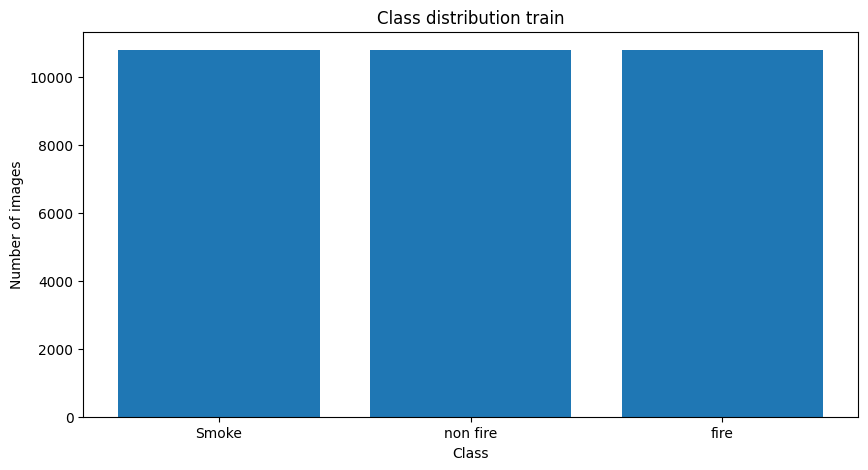

In [6]:
plot_class_distribution(train_dir, "train")

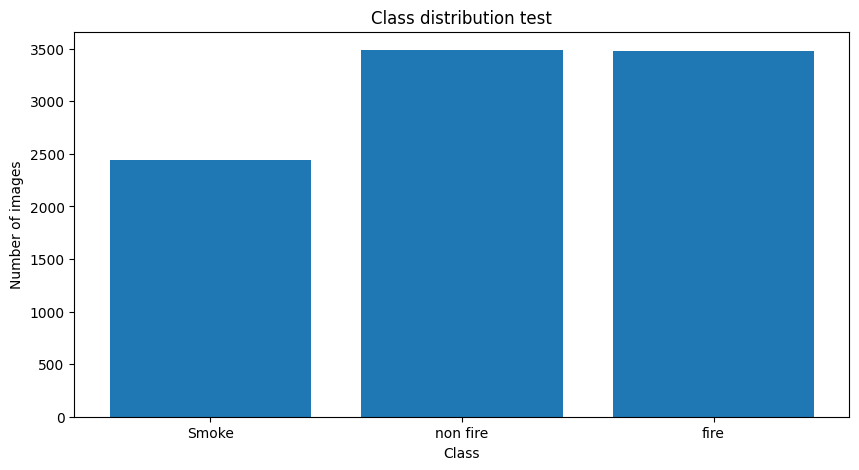

In [7]:
plot_class_distribution(test_dir, "test")

Good news; Classes are evenly distributed in the train set!

### Helper Classes and Functions

Let's apply data normalization to all datasets, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [8]:
class DatasetPreparer:
    def __init__(self):
        self.data_augmentation = self._create_augmentation_pipeline()

    def _create_augmentation_pipeline(self):
        '''Create the data augmentation pipeline'''
        return tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        ])

    def preprocess_image(self, image):
        '''Convert image to float32 and normalize'''
        return tf.image.convert_image_dtype(image, tf.float32) / 255.0

    def augment_and_preprocess(self, image, augment):
        '''Apply data augmentation and preprocess the image'''
        if augment:
            image = self.data_augmentation(image)
        return self.preprocess_image(image)

    def prepare_dataset(self, dataset, augment=False):
        '''Prepare a single dataset split for training'''
        dataset = dataset.map(lambda x, y: (self.augment_and_preprocess(x, augment), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return dataset
    

In [9]:
def plot_history(history):
    '''Function to plot the training and validation history'''
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()

In [19]:
def metrics(model, class_names, test_ds):
    '''Function to calculate the metrics of the model'''
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f"Loss: {test_loss}")
    print(f"Accuracy: {test_accuracy}")
    print("\n")
    
    # Make predictions
    predictions = model.predict(test_ds)
    y_pred = np.argmax(predictions, axis=1)
    
    # Get the true labels
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_true = np.argmax(y_true, axis=1)
    
    # Print classification report
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred))
    
    # Generate confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
# Extract the class names
class_names = test_dataset.class_names

### Model Creation

#### Custom CNN Model 1

Let's begin by creating a small model with one Convolutional layer followed by one Dense

In [ ]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=False)  
validation_ds = dataset_preparer.prepare_dataset(validation_dataset, augment=False)  
test_ds = dataset_preparer.prepare_dataset(test_dataset, augment=False) 

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout

tf.keras.backend.clear_session()

# Define the input shape
input_shape = (224, 224, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# 1st Convolutional  Block
x = Conv2D(32, (3, 3))(inputs)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output
x = Flatten()(x)
# Fully connected layer
x = Dense(32, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_1 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 394272)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                12616736  
                                                           

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

my_callbacks = [

    ModelCheckpoint(
    'best_custom_model_1.keras',
     save_best_only=True,
     monitor='val_loss',
     mode='min',
     verbose=2),

    EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto")

]

In [17]:
# Create a new model
history = model.fit(train_ds, validation_data=validation_ds, epochs=50, callbacks=my_callbacks)

Epoch 1/50
792/793 [============================>.] - ETA: 0s - loss: 0.3680 - accuracy: 0.9148
Epoch 1: val_loss improved from inf to 0.17957, saving model to best_custom_model_1.keras
793/793 [==============================] - 21s 25ms/step - loss: 0.3681 - accuracy: 0.9148 - val_loss: 0.1796 - val_accuracy: 0.9461
Epoch 2/50
793/793 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9620
Epoch 2: val_loss did not improve from 0.17957
793/793 [==============================] - 19s 24ms/step - loss: 0.1239 - accuracy: 0.9620 - val_loss: 0.1880 - val_accuracy: 0.9525
Epoch 3/50
792/793 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9795
Epoch 3: val_loss did not improve from 0.17957
793/793 [==============================] - 19s 24ms/step - loss: 0.0707 - accuracy: 0.9795 - val_loss: 0.2072 - val_accuracy: 0.9555
Epoch 4/50
793/793 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9834
Epoch 4: val_loss did not improve

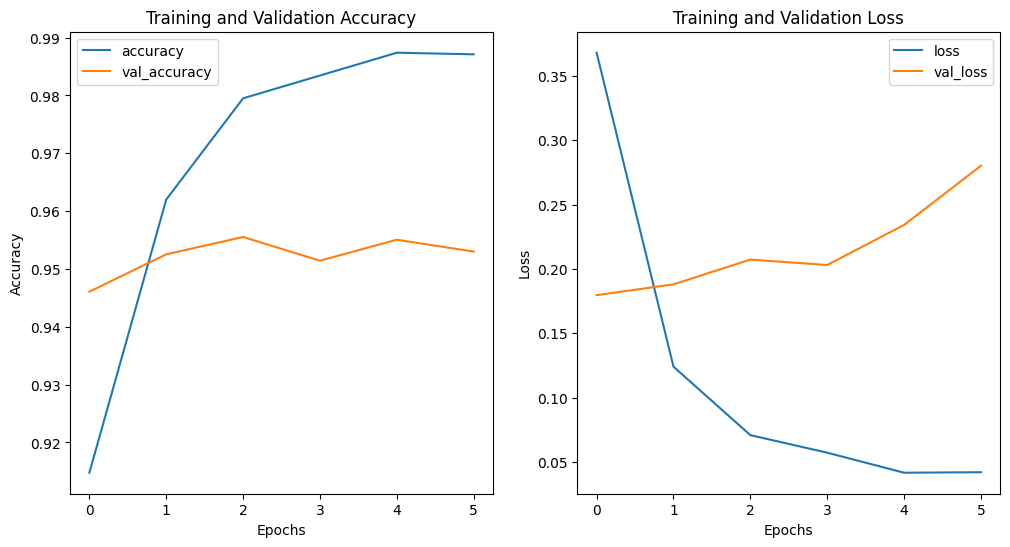

In [18]:
plot_history(history)

Our model has high accuracy and low training loss, but simultaneously has relatively lower validation accuracy and increasing validation loss. That indicates overfitting, meaning our model might not generalize well to unseen data.

172/326 [==============>...............] - ETA: 4s - loss: 0.7199 - accuracy: 0.7920

2024-07-05 22:41:04.653025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 10s 30ms/step - loss: 0.4682 - accuracy: 0.8581
Loss: 0.4681836664676666
Accuracy: 0.8580899238586426


172/326 [==============>...............] - ETA: 4s

2024-07-05 22:41:14.715823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 10s 30ms/step


2024-07-05 22:41:24.376612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


              precision    recall  f1-score   support

           0       0.81      0.98      0.89      3476
           1       0.85      0.91      0.88      3487
           2       0.95      0.68      0.80      3445

    accuracy                           0.86     10408
   macro avg       0.87      0.86      0.85     10408
weighted avg       0.87      0.86      0.85     10408



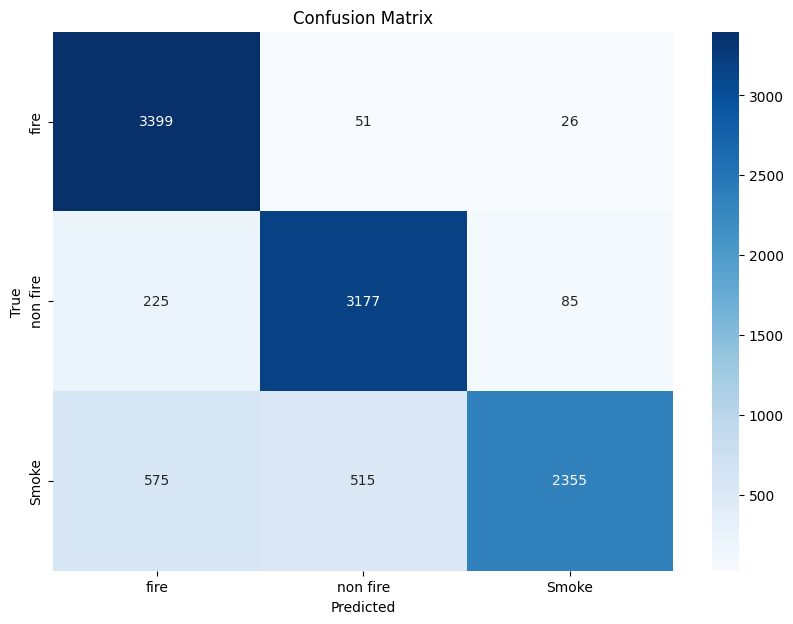

In [16]:
from tensorflow import keras

# Load the best model
best_model = keras.models.load_model('best_custom_model_1.keras')

metrics(best_model, class_names, test_ds)

My previous assumption seems to be correct. Although our model perfroms fairly well, its accuracy on unseen data is 0.13% lower.

#### Custom CNN Model 2

Overfitting means that our model is already too powerful thus adding more layers seems like a bad idea at the moment. However I'll add a BatchNormalization and a Dropout layer, to improve generalization.

In [ ]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=False)  
validation_ds = dataset_preparer.prepare_dataset(validation_dataset, augment=False)  
test_ds = dataset_preparer.prepare_dataset(test_dataset, augment=False) 

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

tf.keras.backend.clear_session()

# Define the input shape
input_shape = (224, 224, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# 1st Convolutional  Block
x = Conv2D(32, (3, 3))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output
x = Flatten()(x)
# Fully connected layers
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0     

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

my_callbacks = [

    ModelCheckpoint(
    'best_custom_model_2.keras',
     save_best_only=True,
     monitor='val_loss',
     mode='min',
     verbose=2),

    EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto")

]

In [9]:
history_2 = model.fit(train_ds, validation_data=validation_ds, epochs=50, callbacks=my_callbacks)

Epoch 1/50


2024-06-30 17:29:27.556373: I external/local_xla/xla/service/service.cc:168] XLA service 0x78c7bb3acae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-30 17:29:27.556390: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-06-30 17:29:27.559383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719757767.624495   12781 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


395/806 [=============>................] - ETA: 2:19 - loss: 1.8466 - accuracy: 0.6924

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 1.2776 - accuracy: 0.6714

2024-06-30 17:34:44.760304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 1: val_loss improved from inf to 0.69695, saving model to best_custom_model_2.keras
806/806 [==============================] - 326s 397ms/step - loss: 1.2776 - accuracy: 0.6714 - val_loss: 0.6969 - val_accuracy: 0.6213
Epoch 2/50
371/806 [============>.................] - ETA: 15s - loss: 0.7162 - accuracy: 0.6146

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.7186 - accuracy: 0.6217

2024-06-30 17:35:22.450734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 2: val_loss did not improve from 0.69695
806/806 [==============================] - 37s 45ms/step - loss: 0.7185 - accuracy: 0.6217 - val_loss: 0.7267 - val_accuracy: 0.5843
Epoch 3/50
371/806 [============>.................] - ETA: 15s - loss: 0.6667 - accuracy: 0.6556

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.6979 - accuracy: 0.6373

2024-06-30 17:35:59.103113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 3: val_loss did not improve from 0.69695
806/806 [==============================] - 37s 45ms/step - loss: 0.6979 - accuracy: 0.6374 - val_loss: 0.7445 - val_accuracy: 0.6056
Epoch 4/50
373/806 [============>.................] - ETA: 16s - loss: 0.6884 - accuracy: 0.6278

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.6677 - accuracy: 0.6495

2024-06-30 17:36:36.140705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 4: val_loss did not improve from 0.69695
806/806 [==============================] - 37s 45ms/step - loss: 0.6675 - accuracy: 0.6496 - val_loss: 0.6988 - val_accuracy: 0.6093
Epoch 5/50
373/806 [============>.................] - ETA: 15s - loss: 0.7404 - accuracy: 0.6472

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.7008 - accuracy: 0.6700

2024-06-30 17:37:12.896219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 5: val_loss did not improve from 0.69695
806/806 [==============================] - 37s 45ms/step - loss: 0.7008 - accuracy: 0.6700 - val_loss: 0.7751 - val_accuracy: 0.5716
Epoch 6/50
373/806 [============>.................] - ETA: 15s - loss: 0.6251 - accuracy: 0.7135

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.5585 - accuracy: 0.7634

2024-06-30 17:37:49.533755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 6: val_loss improved from 0.69695 to 0.39811, saving model to best_custom_model_2.keras
806/806 [==============================] - 37s 45ms/step - loss: 0.5584 - accuracy: 0.7634 - val_loss: 0.3981 - val_accuracy: 0.8735
Epoch 7/50
369/806 [============>.................] - ETA: 16s - loss: 0.4457 - accuracy: 0.8366

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.4294 - accuracy: 0.8451

2024-06-30 17:38:27.916317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 7: val_loss improved from 0.39811 to 0.30694, saving model to best_custom_model_2.keras
806/806 [==============================] - 39s 47ms/step - loss: 0.4294 - accuracy: 0.8451 - val_loss: 0.3069 - val_accuracy: 0.9148
Epoch 8/50
371/806 [============>.................] - ETA: 16s - loss: 0.4047 - accuracy: 0.8549

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.4054 - accuracy: 0.8556

2024-06-30 17:39:06.617689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 8: val_loss improved from 0.30694 to 0.26373, saving model to best_custom_model_2.keras
806/806 [==============================] - 39s 47ms/step - loss: 0.4054 - accuracy: 0.8556 - val_loss: 0.2637 - val_accuracy: 0.9325
Epoch 9/50
369/806 [============>.................] - ETA: 16s - loss: 0.3682 - accuracy: 0.8684

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.3622 - accuracy: 0.8705

2024-06-30 17:39:45.122442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 9: val_loss did not improve from 0.26373
806/806 [==============================] - 38s 46ms/step - loss: 0.3621 - accuracy: 0.8705 - val_loss: 0.3042 - val_accuracy: 0.9279
Epoch 10/50
371/806 [============>.................] - ETA: 16s - loss: 0.3545 - accuracy: 0.8737

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.3703 - accuracy: 0.8687

2024-06-30 17:40:23.297210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 10: val_loss did not improve from 0.26373
806/806 [==============================] - 38s 47ms/step - loss: 0.3701 - accuracy: 0.8688 - val_loss: 0.2849 - val_accuracy: 0.9052
Epoch 11/50
369/806 [============>.................] - ETA: 16s - loss: 0.3422 - accuracy: 0.8799

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8835

2024-06-30 17:41:02.001461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 11: val_loss did not improve from 0.26373
806/806 [==============================] - 39s 47ms/step - loss: 0.3349 - accuracy: 0.8835 - val_loss: 0.2653 - val_accuracy: 0.9179
Epoch 12/50
369/806 [============>.................] - ETA: 16s - loss: 0.3202 - accuracy: 0.8911

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.3166 - accuracy: 0.8914

2024-06-30 17:41:40.156254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 12: val_loss did not improve from 0.26373
806/806 [==============================] - 38s 46ms/step - loss: 0.3167 - accuracy: 0.8915 - val_loss: 0.2891 - val_accuracy: 0.9221
Epoch 13/50
371/806 [============>.................] - ETA: 16s - loss: 0.2945 - accuracy: 0.9019

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.9028

2024-06-30 17:42:18.335371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 13: val_loss improved from 0.26373 to 0.26269, saving model to best_custom_model_2.keras
806/806 [==============================] - 39s 48ms/step - loss: 0.2889 - accuracy: 0.9028 - val_loss: 0.2627 - val_accuracy: 0.9325
Epoch 14/50
370/806 [============>.................] - ETA: 16s - loss: 0.2799 - accuracy: 0.9040

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.9056

2024-06-30 17:42:57.162429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 14: val_loss did not improve from 0.26269
806/806 [==============================] - 38s 46ms/step - loss: 0.2774 - accuracy: 0.9056 - val_loss: 0.3573 - val_accuracy: 0.9078
Epoch 15/50
371/806 [============>.................] - ETA: 16s - loss: 0.2548 - accuracy: 0.9155

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.2571 - accuracy: 0.9114

2024-06-30 17:43:35.212700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 15: val_loss did not improve from 0.26269
806/806 [==============================] - 38s 46ms/step - loss: 0.2573 - accuracy: 0.9113 - val_loss: 0.3994 - val_accuracy: 0.9033
Epoch 16/50
371/806 [============>.................] - ETA: 16s - loss: 0.2570 - accuracy: 0.9145

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.9137

2024-06-30 17:44:12.091769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 16: val_loss improved from 0.26269 to 0.21792, saving model to best_custom_model_2.keras
806/806 [==============================] - 38s 46ms/step - loss: 0.2569 - accuracy: 0.9137 - val_loss: 0.2179 - val_accuracy: 0.9474
Epoch 17/50
373/806 [============>.................] - ETA: 15s - loss: 0.2590 - accuracy: 0.9138

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.2543 - accuracy: 0.9165

2024-06-30 17:44:49.698718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 17: val_loss did not improve from 0.21792
806/806 [==============================] - 37s 45ms/step - loss: 0.2542 - accuracy: 0.9165 - val_loss: 0.2594 - val_accuracy: 0.9085
Epoch 18/50
371/806 [============>.................] - ETA: 16s - loss: 0.2464 - accuracy: 0.9178

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.9182

2024-06-30 17:45:27.395025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 18: val_loss did not improve from 0.21792
806/806 [==============================] - 38s 46ms/step - loss: 0.2435 - accuracy: 0.9182 - val_loss: 0.2927 - val_accuracy: 0.9176
Epoch 19/50
371/806 [============>.................] - ETA: 16s - loss: 0.2544 - accuracy: 0.9127

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.9174

2024-06-30 17:46:05.026770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 19: val_loss did not improve from 0.21792
806/806 [==============================] - 38s 46ms/step - loss: 0.2481 - accuracy: 0.9174 - val_loss: 0.4206 - val_accuracy: 0.8964
Epoch 20/50
369/806 [============>.................] - ETA: 16s - loss: 0.2249 - accuracy: 0.9273

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9310

2024-06-30 17:46:43.447161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 20: val_loss did not improve from 0.21792
806/806 [==============================] - 38s 47ms/step - loss: 0.2165 - accuracy: 0.9310 - val_loss: 0.2574 - val_accuracy: 0.9472
Epoch 21/50
369/806 [============>.................] - ETA: 16s - loss: 0.2146 - accuracy: 0.9321

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.2170 - accuracy: 0.9316

2024-06-30 17:47:22.052966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 21: val_loss improved from 0.21792 to 0.21521, saving model to best_custom_model_2.keras
806/806 [==============================] - 39s 48ms/step - loss: 0.2170 - accuracy: 0.9317 - val_loss: 0.2152 - val_accuracy: 0.9365
Epoch 22/50
371/806 [============>.................] - ETA: 16s - loss: 0.2040 - accuracy: 0.9364

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9392

2024-06-30 17:48:00.619278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 22: val_loss did not improve from 0.21521
806/806 [==============================] - 38s 46ms/step - loss: 0.1954 - accuracy: 0.9392 - val_loss: 0.3730 - val_accuracy: 0.9184
Epoch 23/50
371/806 [============>.................] - ETA: 16s - loss: 0.1957 - accuracy: 0.9395

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9383

2024-06-30 17:48:38.540346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 23: val_loss did not improve from 0.21521
806/806 [==============================] - 38s 46ms/step - loss: 0.1985 - accuracy: 0.9383 - val_loss: 0.3280 - val_accuracy: 0.9415
Epoch 24/50
369/806 [============>.................] - ETA: 16s - loss: 0.2014 - accuracy: 0.9376

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9415

2024-06-30 17:49:16.668728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 24: val_loss did not improve from 0.21521
806/806 [==============================] - 38s 47ms/step - loss: 0.1912 - accuracy: 0.9415 - val_loss: 0.3030 - val_accuracy: 0.9454
Epoch 25/50
371/806 [============>.................] - ETA: 16s - loss: 0.1967 - accuracy: 0.9388

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9413

2024-06-30 17:49:54.631897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 25: val_loss did not improve from 0.21521
806/806 [==============================] - 38s 46ms/step - loss: 0.1920 - accuracy: 0.9413 - val_loss: 0.2657 - val_accuracy: 0.9434
Epoch 26/50
369/806 [============>.................] - ETA: 16s - loss: 0.1791 - accuracy: 0.9455

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.1826 - accuracy: 0.9448

2024-06-30 17:50:32.749678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 26: val_loss did not improve from 0.21521
806/806 [==============================] - 38s 47ms/step - loss: 0.1827 - accuracy: 0.9448 - val_loss: 0.2602 - val_accuracy: 0.9476
Epoch 26: early stopping


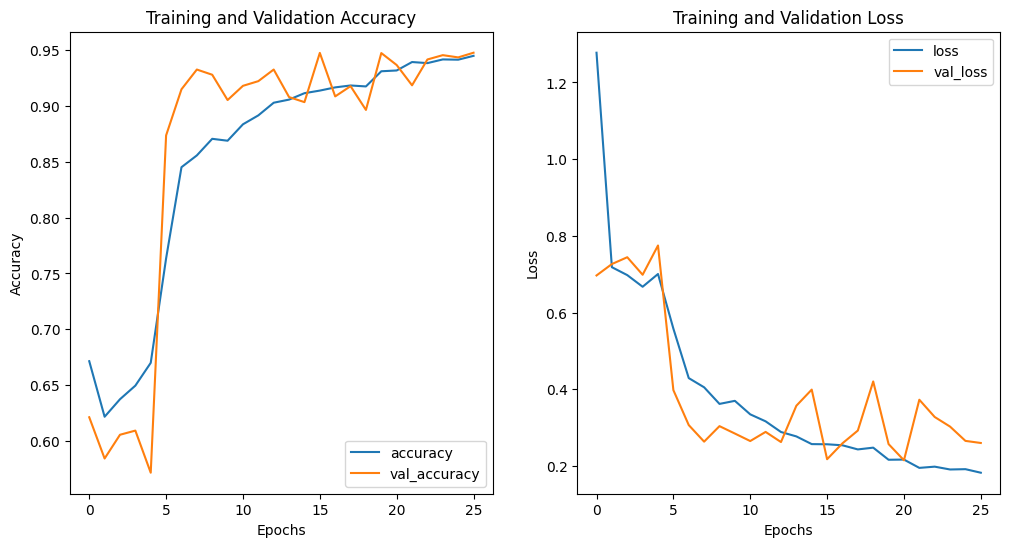

In [10]:
plot_history(history_2)

This time the model shows a good balance between training performance and validation performance, indicating effective learning and generalization.

172/326 [==============>...............] - ETA: 4s - loss: 0.1897 - accuracy: 0.9469

2024-07-05 22:40:11.468664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 10s 29ms/step - loss: 0.2096 - accuracy: 0.9344
Loss: 0.20961138606071472
Accuracy: 0.9343773722648621


172/326 [==============>...............] - ETA: 4s

2024-07-05 22:40:21.161002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 10s 30ms/step


2024-07-05 22:40:30.744705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


              precision    recall  f1-score   support

           0       0.89      1.00      0.94      3476
           1       0.94      0.89      0.91      3487
           2       0.98      0.92      0.95      3445

    accuracy                           0.93     10408
   macro avg       0.94      0.93      0.93     10408
weighted avg       0.94      0.93      0.93     10408



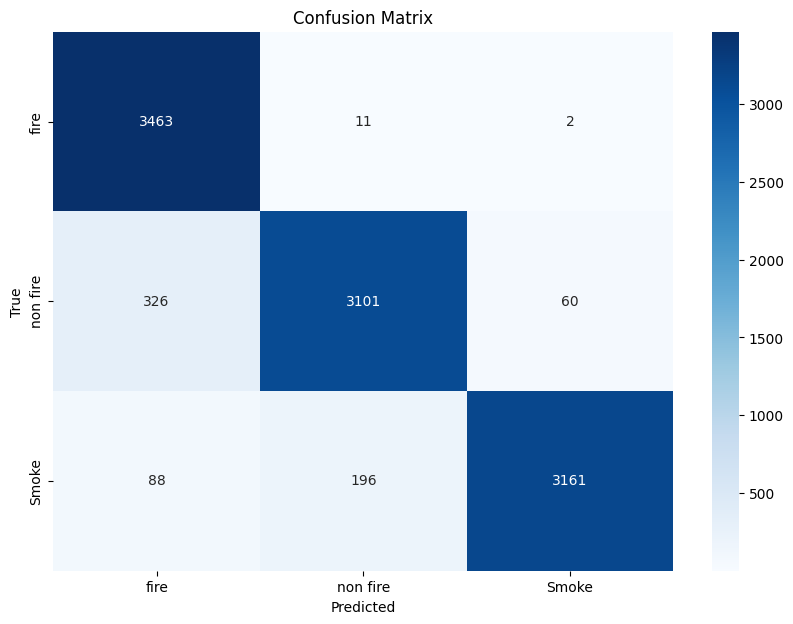

In [15]:
from tensorflow import keras

# Load the best model
best_model = keras.models.load_model('best_custom_model_2.keras')

metrics(best_model, class_names, test_ds)

Test accuracy improved by 0,08%.

#### Custom CNN Model 3

This time I'm going to experiment with increasing the size of the neural network to see if it leads to performance improvements.

In [9]:
# Prepare the dataset
dataset_preparer = DatasetPreparer()

augmented_train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=False)  
validation_ds = dataset_preparer.prepare_dataset(validation_dataset, augment=False)  
test_ds = dataset_preparer.prepare_dataset(test_dataset, augment=False) 

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

tf.keras.backend.clear_session()

# Define the input shape
input_shape = (224, 224, 3)

# Define the input layer
inputs = Input(shape=input_shape)

# 1st Convolutional  Block
x = Conv2D(32, (3, 3))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# 2nd Convolutional  Block
x = Conv2D(64, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# 3rd Convolutional  Block
x = Conv2D(128, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output
x = Flatten()(x)
# Fully connected layers
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496 

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

my_callbacks = [

    ModelCheckpoint(
    'best_custom_model_3.keras',
     save_best_only=True,
     monitor='val_loss',
     mode='min',
     verbose=2),

    EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto")

]

In [12]:
history_3 = model.fit(augmented_train_ds, validation_data=validation_ds, epochs=50, callbacks=my_callbacks)

Epoch 1/50


2024-07-04 19:00:33.722449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-04 19:00:35.562114: I external/local_xla/xla/service/service.cc:168] XLA service 0x7693f8bf9e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-04 19:00:35.562137: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-07-04 19:00:35.579282: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720108835.674491    6952 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


395/806 [=============>................] - ETA: 2:11 - loss: 1.0961 - accuracy: 0.7043

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.7442

2024-07-04 19:05:39.401752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 1: val_loss improved from inf to 0.48072, saving model to best_custom_model_3.keras
806/806 [==============================] - 338s 408ms/step - loss: 0.8426 - accuracy: 0.7442 - val_loss: 0.4807 - val_accuracy: 0.8870
Epoch 2/50
372/806 [============>.................] - ETA: 25s - loss: 0.4648 - accuracy: 0.8529

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.4164 - accuracy: 0.8694

2024-07-04 19:06:58.904497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 2: val_loss improved from 0.48072 to 0.37130, saving model to best_custom_model_3.keras
806/806 [==============================] - 55s 68ms/step - loss: 0.4164 - accuracy: 0.8695 - val_loss: 0.3713 - val_accuracy: 0.8984
Epoch 3/50
372/806 [============>.................] - ETA: 25s - loss: 0.3385 - accuracy: 0.8992

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.3141 - accuracy: 0.9060

2024-07-04 19:07:53.952133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 3: val_loss improved from 0.37130 to 0.21416, saving model to best_custom_model_3.keras
806/806 [==============================] - 55s 68ms/step - loss: 0.3142 - accuracy: 0.9060 - val_loss: 0.2142 - val_accuracy: 0.9432
Epoch 4/50
372/806 [============>.................] - ETA: 25s - loss: 0.2797 - accuracy: 0.9149

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9196

2024-07-04 19:08:49.256675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 4: val_loss did not improve from 0.21416
806/806 [==============================] - 55s 68ms/step - loss: 0.2631 - accuracy: 0.9196 - val_loss: 0.2786 - val_accuracy: 0.9195
Epoch 5/50
372/806 [============>.................] - ETA: 25s - loss: 0.2444 - accuracy: 0.9228

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9247

2024-07-04 19:09:44.270213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 5: val_loss improved from 0.21416 to 0.20264, saving model to best_custom_model_3.keras
806/806 [==============================] - 55s 68ms/step - loss: 0.2351 - accuracy: 0.9247 - val_loss: 0.2026 - val_accuracy: 0.9438
Epoch 6/50
372/806 [============>.................] - ETA: 25s - loss: 0.2297 - accuracy: 0.9241

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9268

2024-07-04 19:10:39.418081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 6: val_loss improved from 0.20264 to 0.18471, saving model to best_custom_model_3.keras
806/806 [==============================] - 55s 68ms/step - loss: 0.2212 - accuracy: 0.9268 - val_loss: 0.1847 - val_accuracy: 0.9434
Epoch 7/50
372/806 [============>.................] - ETA: 25s - loss: 0.2176 - accuracy: 0.9301

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2139 - accuracy: 0.9307

2024-07-04 19:11:34.764661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 7: val_loss improved from 0.18471 to 0.17115, saving model to best_custom_model_3.keras
806/806 [==============================] - 55s 68ms/step - loss: 0.2139 - accuracy: 0.9307 - val_loss: 0.1711 - val_accuracy: 0.9531
Epoch 8/50
372/806 [============>.................] - ETA: 25s - loss: 0.2131 - accuracy: 0.9313

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9353

2024-07-04 19:12:29.421164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 8: val_loss did not improve from 0.17115
806/806 [==============================] - 54s 67ms/step - loss: 0.2022 - accuracy: 0.9353 - val_loss: 0.2449 - val_accuracy: 0.9198
Epoch 9/50
372/806 [============>.................] - ETA: 25s - loss: 0.2013 - accuracy: 0.9352

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1921 - accuracy: 0.9395

2024-07-04 19:13:23.865187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 9: val_loss did not improve from 0.17115
806/806 [==============================] - 54s 67ms/step - loss: 0.1921 - accuracy: 0.9395 - val_loss: 0.1726 - val_accuracy: 0.9527
Epoch 10/50
372/806 [============>.................] - ETA: 25s - loss: 0.2062 - accuracy: 0.9366

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9418

2024-07-04 19:14:18.133036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 10: val_loss improved from 0.17115 to 0.15991, saving model to best_custom_model_3.keras
806/806 [==============================] - 55s 67ms/step - loss: 0.1875 - accuracy: 0.9418 - val_loss: 0.1599 - val_accuracy: 0.9555
Epoch 11/50
372/806 [============>.................] - ETA: 25s - loss: 0.1955 - accuracy: 0.9425

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1792 - accuracy: 0.9455

2024-07-04 19:15:12.613569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 11: val_loss improved from 0.15991 to 0.14625, saving model to best_custom_model_3.keras
806/806 [==============================] - 54s 67ms/step - loss: 0.1792 - accuracy: 0.9455 - val_loss: 0.1463 - val_accuracy: 0.9631
Epoch 12/50
372/806 [============>.................] - ETA: 25s - loss: 0.1709 - accuracy: 0.9479

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1573 - accuracy: 0.9529

2024-07-04 19:16:07.167442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 12: val_loss did not improve from 0.14625
806/806 [==============================] - 54s 67ms/step - loss: 0.1573 - accuracy: 0.9529 - val_loss: 0.1528 - val_accuracy: 0.9545
Epoch 13/50
372/806 [============>.................] - ETA: 24s - loss: 0.1607 - accuracy: 0.9526

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.9542

2024-07-04 19:17:00.395570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 13: val_loss did not improve from 0.14625
806/806 [==============================] - 53s 65ms/step - loss: 0.1554 - accuracy: 0.9542 - val_loss: 0.2137 - val_accuracy: 0.9328
Epoch 14/50
372/806 [============>.................] - ETA: 24s - loss: 0.1464 - accuracy: 0.9560

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9566

2024-07-04 19:17:53.430844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 14: val_loss did not improve from 0.14625
806/806 [==============================] - 53s 65ms/step - loss: 0.1453 - accuracy: 0.9566 - val_loss: 0.1667 - val_accuracy: 0.9575
Epoch 15/50
372/806 [============>.................] - ETA: 24s - loss: 0.1562 - accuracy: 0.9540

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 0.1423 - accuracy: 0.9583

2024-07-04 19:18:46.412714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 15: val_loss did not improve from 0.14625
806/806 [==============================] - 53s 65ms/step - loss: 0.1423 - accuracy: 0.9583 - val_loss: 0.1671 - val_accuracy: 0.9569
Epoch 16/50
372/806 [============>.................] - ETA: 26s - loss: 0.1406 - accuracy: 0.9593

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9621

2024-07-04 19:19:41.651447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 16: val_loss did not improve from 0.14625
806/806 [==============================] - 55s 68ms/step - loss: 0.1296 - accuracy: 0.9621 - val_loss: 0.1810 - val_accuracy: 0.9587
Epoch 16: early stopping


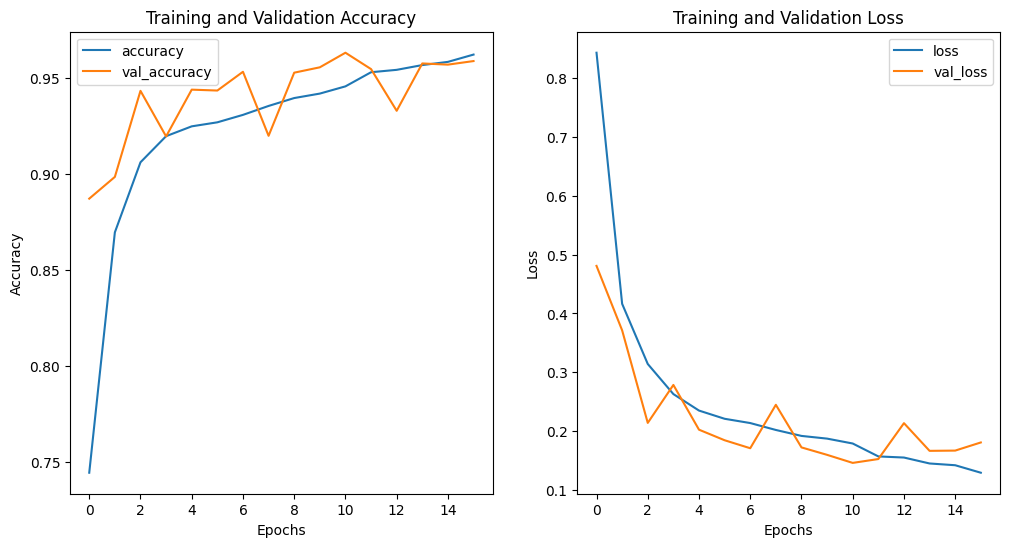

In [13]:
plot_history(history_3)

The model appears to be learning effectively and generalizing well to the validation data, also the training and validation metrics indicate a well-trained model with good performance.

172/326 [==============>...............] - ETA: 4s - loss: 0.1693 - accuracy: 0.9528

2024-07-05 22:39:06.667012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 12s 33ms/step - loss: 0.1498 - accuracy: 0.9576
Loss: 0.14982056617736816
Accuracy: 0.9576287269592285


172/326 [==============>...............] - ETA: 4s

2024-07-05 22:39:17.444225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 10s 31ms/step


2024-07-05 22:39:27.158031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3476
           1       0.93      0.96      0.95      3487
           2       0.98      0.94      0.96      3445

    accuracy                           0.96     10408
   macro avg       0.96      0.96      0.96     10408
weighted avg       0.96      0.96      0.96     10408



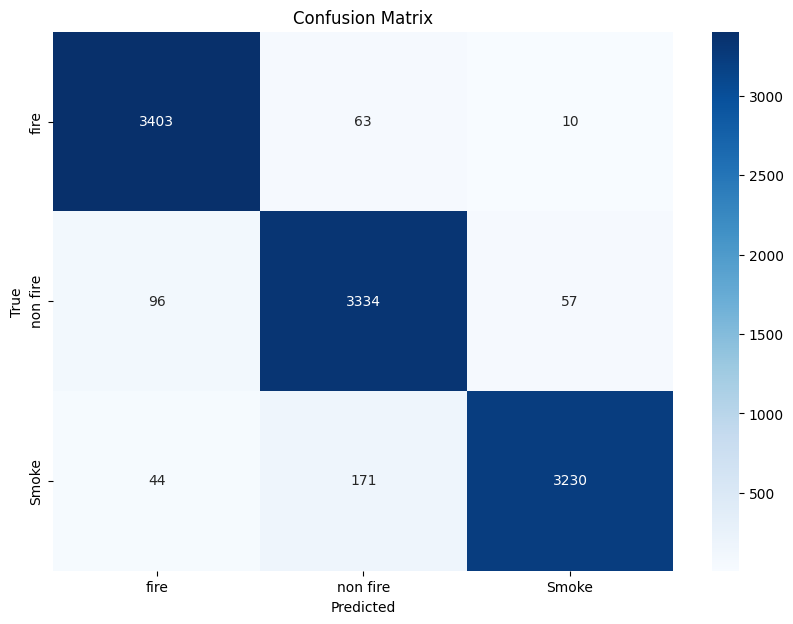

In [14]:
from tensorflow import keras

# Load the best model
best_model = keras.models.load_model('best_custom_model_3.keras')

metrics(best_model, class_names, test_ds)

The test accuracy improved by 0,02%, which is not significant, but if we add more layers we might improve performace a little bit more

### Custom CNN model 4

There is a risk in making a network more powerful by adding layers, which is called overfitting. To counter that I'll apply some augmentation to the train set, to increase its size and diversity. Also there is another risk of vanishing gradients; if a model is too large, information can get lost. To address that I'll add some residual layers.

In [34]:
dataset_preparer = DatasetPreparer()

augmented_train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=True)  
validation_ds = dataset_preparer.prepare_dataset(validation_dataset, augment=False)  
test_ds = dataset_preparer.prepare_dataset(test_dataset, augment=False) 

In [35]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout, add
tf.keras.backend.clear_session()

# Define the input shape
input_shape = (224, 224, 3)

# Define the residual block
def residual_block(x, filters, pooling=False):
    residual = x
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if pooling:
        x = MaxPooling2D(2, padding='same')(x)
        residual = Conv2D(filters, 1, strides=2, padding='same')(residual)
    elif filters != residual.shape[-1]:
        residual = Conv2D(filters, 1, padding='same')(residual)
    
    x = add([x, residual])
    return x

# Define the input layer
inputs = Input(shape=input_shape)

# 1st Convolutional Block
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Add residual connection for the 1st block
x = residual_block(x, 32)

# 2nd Convolutional Block
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Add residual connection for the 2nd block with pooling
x = residual_block(x, 64, pooling=True)

# 3rd Convolutional Block
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = residual_block(x, 128)

# 4th Convolutional Block
x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

x = residual_block(x, 256)

# 4th Convolutional Block
x = Conv2D(512, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output
x = Flatten()(x)

# Fully connected layers
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 32)         0         ['batch_normalization[0][0

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

my_callbacks = [

    ModelCheckpoint(
    'best_custom_model_4.keras',
     save_best_only=True,
     monitor='val_loss',
     mode='min',
     verbose=2),

    EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto")

]

In [37]:
history_4 = model.fit(augmented_train_ds, validation_data=validation_ds, epochs=50, callbacks=my_callbacks)

Epoch 1/50
372/806 [============>.................] - ETA: 37s - loss: 0.4158 - accuracy: 0.8474

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3588 - accuracy: 0.8673

2024-07-04 20:06:15.684317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 1: val_loss improved from inf to 0.38012, saving model to best_custom_model_4.keras
806/806 [==============================] - 83s 98ms/step - loss: 0.3588 - accuracy: 0.8673 - val_loss: 0.3801 - val_accuracy: 0.8956
Epoch 2/50
371/806 [============>.................] - ETA: 40s - loss: 0.2699 - accuracy: 0.8991

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2635 - accuracy: 0.9054

2024-07-04 20:07:38.131397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 2: val_loss improved from 0.38012 to 0.22191, saving model to best_custom_model_4.keras
806/806 [==============================] - 82s 101ms/step - loss: 0.2635 - accuracy: 0.9054 - val_loss: 0.2219 - val_accuracy: 0.9311
Epoch 3/50
371/806 [============>.................] - ETA: 40s - loss: 0.2399 - accuracy: 0.9195

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9223

2024-07-04 20:09:00.616041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 3: val_loss did not improve from 0.22191
806/806 [==============================] - 82s 101ms/step - loss: 0.2351 - accuracy: 0.9223 - val_loss: 1.5317 - val_accuracy: 0.6680
Epoch 4/50
371/806 [============>.................] - ETA: 40s - loss: 0.2281 - accuracy: 0.9233

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2230 - accuracy: 0.9253

2024-07-04 20:10:22.699619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 4: val_loss improved from 0.22191 to 0.20861, saving model to best_custom_model_4.keras
806/806 [==============================] - 82s 101ms/step - loss: 0.2230 - accuracy: 0.9253 - val_loss: 0.2086 - val_accuracy: 0.9358
Epoch 5/50
371/806 [============>.................] - ETA: 39s - loss: 0.2046 - accuracy: 0.9338

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9339

2024-07-04 20:11:42.320143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 5: val_loss improved from 0.20861 to 0.18314, saving model to best_custom_model_4.keras
806/806 [==============================] - 80s 98ms/step - loss: 0.2022 - accuracy: 0.9339 - val_loss: 0.1831 - val_accuracy: 0.9500
Epoch 6/50
371/806 [============>.................] - ETA: 37s - loss: 0.2074 - accuracy: 0.9299

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9331

2024-07-04 20:13:00.645600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 6: val_loss improved from 0.18314 to 0.15520, saving model to best_custom_model_4.keras
806/806 [==============================] - 78s 96ms/step - loss: 0.1956 - accuracy: 0.9331 - val_loss: 0.1552 - val_accuracy: 0.9566
Epoch 7/50
371/806 [============>.................] - ETA: 38s - loss: 0.1809 - accuracy: 0.9394

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1716 - accuracy: 0.9422

2024-07-04 20:14:21.434603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 7: val_loss did not improve from 0.15520
806/806 [==============================] - 80s 99ms/step - loss: 0.1716 - accuracy: 0.9422 - val_loss: 0.2787 - val_accuracy: 0.8993
Epoch 8/50
371/806 [============>.................] - ETA: 40s - loss: 0.1693 - accuracy: 0.9441

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9459

2024-07-04 20:15:43.294870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 8: val_loss improved from 0.15520 to 0.14260, saving model to best_custom_model_4.keras
806/806 [==============================] - 82s 101ms/step - loss: 0.1653 - accuracy: 0.9459 - val_loss: 0.1426 - val_accuracy: 0.9536
Epoch 9/50
371/806 [============>.................] - ETA: 40s - loss: 0.1664 - accuracy: 0.9444

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1608 - accuracy: 0.9468

2024-07-04 20:17:05.353560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 9: val_loss improved from 0.14260 to 0.14121, saving model to best_custom_model_4.keras
806/806 [==============================] - 82s 101ms/step - loss: 0.1608 - accuracy: 0.9468 - val_loss: 0.1412 - val_accuracy: 0.9558
Epoch 10/50
371/806 [============>.................] - ETA: 40s - loss: 0.1550 - accuracy: 0.9517

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9532

2024-07-04 20:18:26.957243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 10: val_loss did not improve from 0.14121
806/806 [==============================] - 81s 100ms/step - loss: 0.1502 - accuracy: 0.9532 - val_loss: 0.2101 - val_accuracy: 0.9263
Epoch 11/50
371/806 [============>.................] - ETA: 39s - loss: 0.1454 - accuracy: 0.9554

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9542

2024-07-04 20:19:48.548310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 11: val_loss did not improve from 0.14121
806/806 [==============================] - 82s 100ms/step - loss: 0.1481 - accuracy: 0.9542 - val_loss: 0.1497 - val_accuracy: 0.9468
Epoch 12/50
371/806 [============>.................] - ETA: 39s - loss: 0.1436 - accuracy: 0.9561

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9567

2024-07-04 20:21:10.240434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 12: val_loss did not improve from 0.14121
806/806 [==============================] - 82s 100ms/step - loss: 0.1397 - accuracy: 0.9567 - val_loss: 0.1525 - val_accuracy: 0.9561
Epoch 13/50
371/806 [============>.................] - ETA: 37s - loss: 0.1470 - accuracy: 0.9556

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9597

2024-07-04 20:22:28.478486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 13: val_loss did not improve from 0.14121
806/806 [==============================] - 78s 96ms/step - loss: 0.1357 - accuracy: 0.9597 - val_loss: 0.2143 - val_accuracy: 0.9283
Epoch 14/50
371/806 [============>.................] - ETA: 38s - loss: 0.1307 - accuracy: 0.9607

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1233 - accuracy: 0.9635

2024-07-04 20:23:48.789686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 14: val_loss improved from 0.14121 to 0.12268, saving model to best_custom_model_4.keras
806/806 [==============================] - 81s 99ms/step - loss: 0.1233 - accuracy: 0.9635 - val_loss: 0.1227 - val_accuracy: 0.9580
Epoch 15/50
371/806 [============>.................] - ETA: 38s - loss: 0.1200 - accuracy: 0.9639

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9645

2024-07-04 20:25:09.079058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 15: val_loss did not improve from 0.12268
806/806 [==============================] - 80s 98ms/step - loss: 0.1164 - accuracy: 0.9645 - val_loss: 0.1523 - val_accuracy: 0.9569
Epoch 16/50
371/806 [============>.................] - ETA: 38s - loss: 0.1138 - accuracy: 0.9650

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9652

2024-07-04 20:26:29.673682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 16: val_loss improved from 0.12268 to 0.11571, saving model to best_custom_model_4.keras
806/806 [==============================] - 81s 99ms/step - loss: 0.1140 - accuracy: 0.9652 - val_loss: 0.1157 - val_accuracy: 0.9640
Epoch 17/50
371/806 [============>.................] - ETA: 38s - loss: 0.1209 - accuracy: 0.9636

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9661

2024-07-04 20:27:48.244004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 17: val_loss did not improve from 0.11571
806/806 [==============================] - 78s 96ms/step - loss: 0.1125 - accuracy: 0.9661 - val_loss: 0.1450 - val_accuracy: 0.9620
Epoch 18/50
371/806 [============>.................] - ETA: 38s - loss: 0.1121 - accuracy: 0.9650

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1059 - accuracy: 0.9672

2024-07-04 20:29:07.232919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 18: val_loss did not improve from 0.11571
806/806 [==============================] - 79s 97ms/step - loss: 0.1059 - accuracy: 0.9672 - val_loss: 0.1188 - val_accuracy: 0.9580
Epoch 19/50
371/806 [============>.................] - ETA: 38s - loss: 0.1117 - accuracy: 0.9673

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9675

2024-07-04 20:30:26.174355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 19: val_loss improved from 0.11571 to 0.11035, saving model to best_custom_model_4.keras
806/806 [==============================] - 79s 97ms/step - loss: 0.1084 - accuracy: 0.9675 - val_loss: 0.1104 - val_accuracy: 0.9687
Epoch 20/50
371/806 [============>.................] - ETA: 40s - loss: 0.1000 - accuracy: 0.9691

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9703

2024-07-04 20:31:47.483397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 20: val_loss did not improve from 0.11035
806/806 [==============================] - 81s 99ms/step - loss: 0.0978 - accuracy: 0.9703 - val_loss: 0.1131 - val_accuracy: 0.9696
Epoch 21/50
371/806 [============>.................] - ETA: 36s - loss: 0.1021 - accuracy: 0.9672

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9699

2024-07-04 20:33:03.105707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 21: val_loss improved from 0.11035 to 0.10736, saving model to best_custom_model_4.keras
806/806 [==============================] - 76s 93ms/step - loss: 0.0996 - accuracy: 0.9699 - val_loss: 0.1074 - val_accuracy: 0.9683
Epoch 22/50
371/806 [============>.................] - ETA: 36s - loss: 0.1008 - accuracy: 0.9693

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9702

2024-07-04 20:34:19.063748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 22: val_loss improved from 0.10736 to 0.10435, saving model to best_custom_model_4.keras
806/806 [==============================] - 76s 93ms/step - loss: 0.0969 - accuracy: 0.9702 - val_loss: 0.1044 - val_accuracy: 0.9715
Epoch 23/50
371/806 [============>.................] - ETA: 36s - loss: 0.0987 - accuracy: 0.9717

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9731

2024-07-04 20:35:35.073505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 23: val_loss did not improve from 0.10435
806/806 [==============================] - 76s 93ms/step - loss: 0.0920 - accuracy: 0.9731 - val_loss: 0.1165 - val_accuracy: 0.9685
Epoch 24/50
371/806 [============>.................] - ETA: 36s - loss: 0.0933 - accuracy: 0.9730

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0889 - accuracy: 0.9742

2024-07-04 20:36:50.613917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 24: val_loss improved from 0.10435 to 0.09419, saving model to best_custom_model_4.keras
806/806 [==============================] - 76s 93ms/step - loss: 0.0889 - accuracy: 0.9742 - val_loss: 0.0942 - val_accuracy: 0.9753
Epoch 25/50
371/806 [============>.................] - ETA: 36s - loss: 0.0886 - accuracy: 0.9744

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0851 - accuracy: 0.9748

2024-07-04 20:38:06.512125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 25: val_loss did not improve from 0.09419
806/806 [==============================] - 76s 93ms/step - loss: 0.0851 - accuracy: 0.9748 - val_loss: 0.1043 - val_accuracy: 0.9741
Epoch 26/50
371/806 [============>.................] - ETA: 36s - loss: 0.0933 - accuracy: 0.9721

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9749

2024-07-04 20:39:22.105770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 26: val_loss did not improve from 0.09419
806/806 [==============================] - 76s 93ms/step - loss: 0.0880 - accuracy: 0.9749 - val_loss: 0.1327 - val_accuracy: 0.9578
Epoch 27/50
371/806 [============>.................] - ETA: 36s - loss: 0.0850 - accuracy: 0.9734

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.9759

2024-07-04 20:40:37.688631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 27: val_loss did not improve from 0.09419
806/806 [==============================] - 75s 93ms/step - loss: 0.0803 - accuracy: 0.9759 - val_loss: 0.0973 - val_accuracy: 0.9701
Epoch 28/50
371/806 [============>.................] - ETA: 36s - loss: 0.0831 - accuracy: 0.9741

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0831 - accuracy: 0.9744

2024-07-04 20:41:52.409493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 28: val_loss did not improve from 0.09419
806/806 [==============================] - 75s 92ms/step - loss: 0.0831 - accuracy: 0.9744 - val_loss: 0.1021 - val_accuracy: 0.9634
Epoch 29/50
371/806 [============>.................] - ETA: 36s - loss: 0.0843 - accuracy: 0.9736

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9748

2024-07-04 20:43:06.593565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 29: val_loss did not improve from 0.09419
806/806 [==============================] - 74s 91ms/step - loss: 0.0797 - accuracy: 0.9748 - val_loss: 0.1526 - val_accuracy: 0.9668
Epoch 29: early stopping


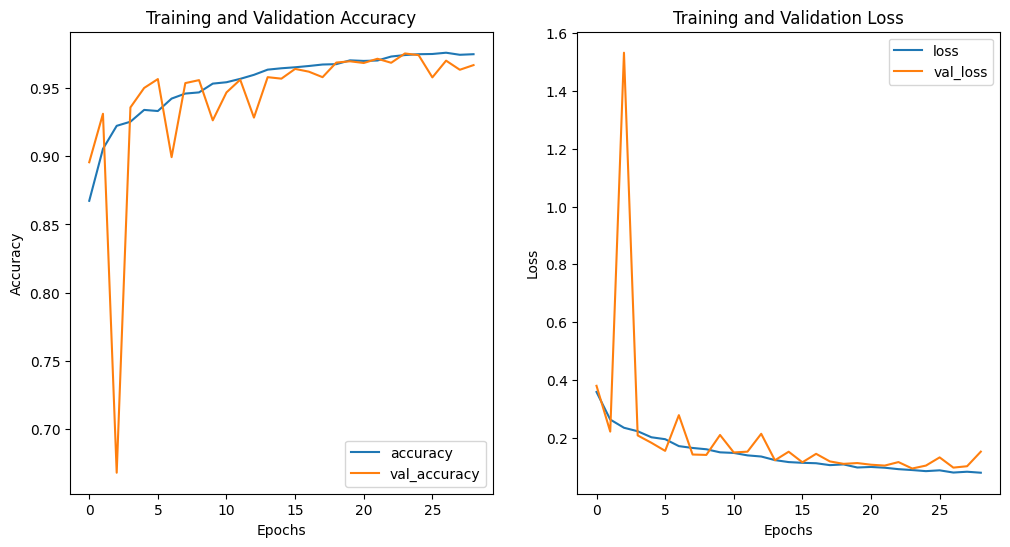

In [38]:
plot_history(history_4)

The close alignment of training and validation metrics generally indicates good generalization, but the instability in validation performance could be a concern.

171/326 [==============>...............] - ETA: 5s - loss: 0.1497 - accuracy: 0.9603

2024-07-05 22:37:45.251817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 15s 39ms/step - loss: 0.1051 - accuracy: 0.9717
Loss: 0.10512053221464157
Accuracy: 0.9716564416885376


172/326 [==============>...............] - ETA: 5s

2024-07-05 22:37:57.953869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 12s 35ms/step


2024-07-05 22:38:08.311980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3476
           1       0.95      0.98      0.97      3487
           2       0.99      0.95      0.97      3445

    accuracy                           0.97     10408
   macro avg       0.97      0.97      0.97     10408
weighted avg       0.97      0.97      0.97     10408



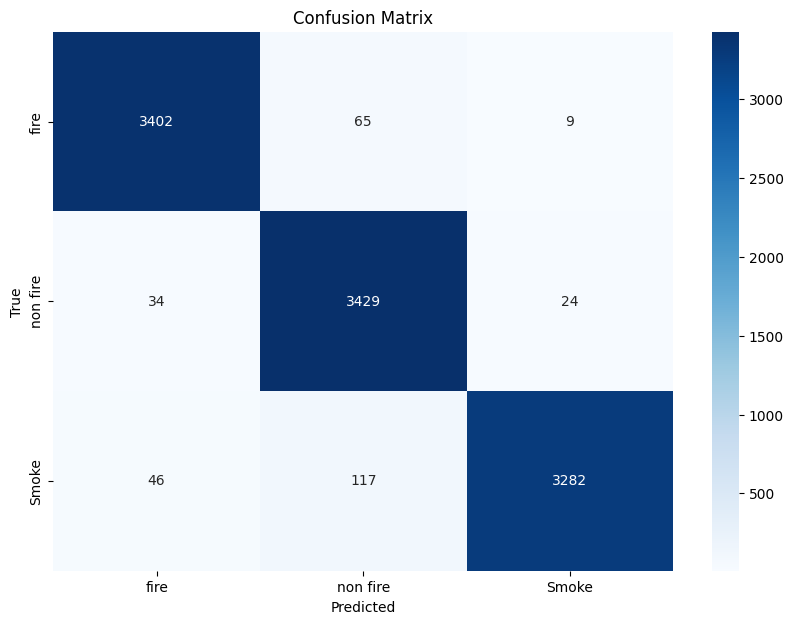

In [13]:
from tensorflow import keras

# Load the best model
best_model = keras.models.load_model('best_custom_model_4.keras')

metrics(best_model, class_names, test_ds)

We have slightly better performance than the previous model (0.01%).

### Transfer Learning

In [11]:
dataset_preparer = DatasetPreparer()

augmented_train_ds = dataset_preparer.prepare_dataset(train_dataset, augment=True)  
validation_ds = dataset_preparer.prepare_dataset(validation_dataset, augment=False)  
test_ds = dataset_preparer.prepare_dataset(test_dataset, augment=False) 

#### EfficientNetB0

In [14]:
from tensorflow.keras.applications import EfficientNetB0

# Load pre-trained EfficientNetB0 model + higher level layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Add custom layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
outputs = Dense(3, activation='softmax')(x)  # Adjust the number of classes

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 4053414 (15.46 MB)
Trainable params: 3843 (15

In [16]:
history_5 = model.fit(augmented_train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
365/806 [============>.................] - ETA: 22s - loss: 1.1201 - accuracy: 0.3396

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 1.1151 - accuracy: 0.3385

2024-07-05 18:53:40.778020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 55s 64ms/step - loss: 1.1151 - accuracy: 0.3385 - val_loss: 1.0988 - val_accuracy: 0.3497
Epoch 2/10
365/806 [============>.................] - ETA: 22s - loss: 1.1055 - accuracy: 0.3525

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 1.1049 - accuracy: 0.3556

2024-07-05 18:54:31.659453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 62ms/step - loss: 1.1048 - accuracy: 0.3558 - val_loss: 1.1035 - val_accuracy: 0.3497
Epoch 3/10
365/806 [============>.................] - ETA: 22s - loss: 1.1010 - accuracy: 0.3601

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 1.0990 - accuracy: 0.3650

2024-07-05 18:55:23.060479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 63ms/step - loss: 1.0990 - accuracy: 0.3650 - val_loss: 1.0782 - val_accuracy: 0.3815
Epoch 4/10
364/806 [============>.................] - ETA: 22s - loss: 1.0935 - accuracy: 0.3741

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 1.0928 - accuracy: 0.3750

2024-07-05 18:56:14.214915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 63ms/step - loss: 1.0929 - accuracy: 0.3749 - val_loss: 1.0724 - val_accuracy: 0.4380
Epoch 5/10
365/806 [============>.................] - ETA: 22s - loss: 1.0857 - accuracy: 0.3887

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 1.0848 - accuracy: 0.3926

2024-07-05 18:57:05.502930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 63ms/step - loss: 1.0848 - accuracy: 0.3925 - val_loss: 1.0627 - val_accuracy: 0.4296
Epoch 6/10
365/806 [============>.................] - ETA: 22s - loss: 1.0846 - accuracy: 0.3909

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 1.0834 - accuracy: 0.3938

2024-07-05 18:57:56.818592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 63ms/step - loss: 1.0834 - accuracy: 0.3937 - val_loss: 1.0603 - val_accuracy: 0.4154
Epoch 7/10
364/806 [============>.................] - ETA: 22s - loss: 1.0839 - accuracy: 0.3919

Invalid SOS parameters for sequential JPEG


805/806 [============================>.] - ETA: 0s - loss: 1.0799 - accuracy: 0.3981

2024-07-05 18:58:48.052409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 63ms/step - loss: 1.0799 - accuracy: 0.3980 - val_loss: 1.0570 - val_accuracy: 0.3804
Epoch 8/10
364/806 [============>.................] - ETA: 22s - loss: 1.0768 - accuracy: 0.4078

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 1.0758 - accuracy: 0.4076

2024-07-05 18:59:39.634703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 63ms/step - loss: 1.0758 - accuracy: 0.4076 - val_loss: 1.0658 - val_accuracy: 0.3995
Epoch 9/10
365/806 [============>.................] - ETA: 22s - loss: 1.0739 - accuracy: 0.4131

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.4114

2024-07-05 19:00:30.385729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 62ms/step - loss: 1.0727 - accuracy: 0.4114 - val_loss: 1.0498 - val_accuracy: 0.4248
Epoch 10/10
365/806 [============>.................] - ETA: 22s - loss: 1.0721 - accuracy: 0.4071

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 1.0716 - accuracy: 0.4118

2024-07-05 19:01:21.343860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


806/806 [==============================] - 51s 62ms/step - loss: 1.0716 - accuracy: 0.4118 - val_loss: 1.0532 - val_accuracy: 0.3724


In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

my_callbacks = [

    ModelCheckpoint(
    'efficientnet_model.keras',
     save_best_only=True,
     monitor='val_loss',
     mode='min',
     verbose=2),

    EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    mode="auto")

]

Now unfreeze the model and continue training with lower LR

In [18]:
# Fine-tune the model
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_6 = model.fit(augmented_train_ds, epochs=50, validation_data=validation_ds, callbacks=my_callbacks)

Epoch 1/50
377/806 [=============>................] - ETA: 1:18 - loss: 1.1053 - accuracy: 0.3970

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.4184

2024-07-05 19:06:00.258839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 1: val_loss improved from inf to 1.00961, saving model to efficientnet_model.keras
806/806 [==============================] - 195s 208ms/step - loss: 1.0823 - accuracy: 0.4184 - val_loss: 1.0096 - val_accuracy: 0.5682
Epoch 2/50
377/806 [=============>................] - ETA: 1:21 - loss: 1.0017 - accuracy: 0.4901

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.9519 - accuracy: 0.5315

2024-07-05 19:08:44.609700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 2: val_loss improved from 1.00961 to 0.83796, saving model to efficientnet_model.keras
806/806 [==============================] - 164s 203ms/step - loss: 0.9519 - accuracy: 0.5315 - val_loss: 0.8380 - val_accuracy: 0.5926
Epoch 3/50
377/806 [=============>................] - ETA: 1:20 - loss: 0.8461 - accuracy: 0.5971

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.8151 - accuracy: 0.6193

2024-07-05 19:11:26.402100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 3: val_loss improved from 0.83796 to 0.72804, saving model to efficientnet_model.keras
806/806 [==============================] - 161s 199ms/step - loss: 0.8151 - accuracy: 0.6193 - val_loss: 0.7280 - val_accuracy: 0.7046
Epoch 4/50
377/806 [=============>................] - ETA: 1:19 - loss: 0.7848 - accuracy: 0.6370

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.7582 - accuracy: 0.6552

2024-07-05 19:14:06.688735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 4: val_loss improved from 0.72804 to 0.63965, saving model to efficientnet_model.keras
806/806 [==============================] - 160s 198ms/step - loss: 0.7582 - accuracy: 0.6552 - val_loss: 0.6397 - val_accuracy: 0.7701
Epoch 5/50
377/806 [=============>................] - ETA: 1:17 - loss: 0.7278 - accuracy: 0.6771

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.6913

2024-07-05 19:16:42.609300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 5: val_loss did not improve from 0.63965
806/806 [==============================] - 155s 192ms/step - loss: 0.7079 - accuracy: 0.6913 - val_loss: 0.8405 - val_accuracy: 0.7071
Epoch 6/50
377/806 [=============>................] - ETA: 1:17 - loss: 0.6649 - accuracy: 0.7244

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.7470

2024-07-05 19:19:17.756068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 6: val_loss improved from 0.63965 to 0.52309, saving model to efficientnet_model.keras
806/806 [==============================] - 156s 192ms/step - loss: 0.6232 - accuracy: 0.7470 - val_loss: 0.5231 - val_accuracy: 0.7916
Epoch 7/50
377/806 [=============>................] - ETA: 1:17 - loss: 0.5177 - accuracy: 0.8001

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.4973 - accuracy: 0.8070

2024-07-05 19:21:53.634113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 7: val_loss improved from 0.52309 to 0.50378, saving model to efficientnet_model.keras
806/806 [==============================] - 156s 192ms/step - loss: 0.4973 - accuracy: 0.8070 - val_loss: 0.5038 - val_accuracy: 0.7744
Epoch 8/50
377/806 [=============>................] - ETA: 1:17 - loss: 0.4631 - accuracy: 0.8218

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.4506 - accuracy: 0.8263

2024-07-05 19:24:29.403302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 8: val_loss improved from 0.50378 to 0.44117, saving model to efficientnet_model.keras
806/806 [==============================] - 156s 192ms/step - loss: 0.4506 - accuracy: 0.8263 - val_loss: 0.4412 - val_accuracy: 0.8318
Epoch 9/50
377/806 [=============>................] - ETA: 1:17 - loss: 0.4101 - accuracy: 0.8387

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8366

2024-07-05 19:27:01.232340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 9: val_loss improved from 0.44117 to 0.36585, saving model to efficientnet_model.keras
806/806 [==============================] - 151s 187ms/step - loss: 0.4152 - accuracy: 0.8366 - val_loss: 0.3658 - val_accuracy: 0.8664
Epoch 10/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.4233 - accuracy: 0.8365

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.8392

2024-07-05 19:29:24.403016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 10: val_loss improved from 0.36585 to 0.33384, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.4145 - accuracy: 0.8392 - val_loss: 0.3338 - val_accuracy: 0.8644
Epoch 11/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3871 - accuracy: 0.8467

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3895 - accuracy: 0.8458

2024-07-05 19:31:47.415434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 11: val_loss improved from 0.33384 to 0.31619, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.3895 - accuracy: 0.8458 - val_loss: 0.3162 - val_accuracy: 0.8683
Epoch 12/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3875 - accuracy: 0.8502

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3774 - accuracy: 0.8534

2024-07-05 19:34:10.782201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 12: val_loss improved from 0.31619 to 0.31526, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.3774 - accuracy: 0.8534 - val_loss: 0.3153 - val_accuracy: 0.8647
Epoch 13/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3566 - accuracy: 0.8635

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3575 - accuracy: 0.8611

2024-07-05 19:36:34.078990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 13: val_loss improved from 0.31526 to 0.29370, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.3575 - accuracy: 0.8611 - val_loss: 0.2937 - val_accuracy: 0.8919
Epoch 14/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3609 - accuracy: 0.8609

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.8637

2024-07-05 19:38:57.406399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 14: val_loss improved from 0.29370 to 0.29089, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.3490 - accuracy: 0.8637 - val_loss: 0.2909 - val_accuracy: 0.8889
Epoch 15/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3359 - accuracy: 0.8698

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3469 - accuracy: 0.8610

2024-07-05 19:41:20.592623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 15: val_loss did not improve from 0.29089
806/806 [==============================] - 142s 176ms/step - loss: 0.3469 - accuracy: 0.8610 - val_loss: 0.3706 - val_accuracy: 0.8524
Epoch 16/50
377/806 [=============>................] - ETA: 1:10 - loss: 0.3389 - accuracy: 0.8693

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3373 - accuracy: 0.8682

2024-07-05 19:43:43.127374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 16: val_loss improved from 0.29089 to 0.27489, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.3373 - accuracy: 0.8682 - val_loss: 0.2749 - val_accuracy: 0.9009
Epoch 17/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3154 - accuracy: 0.8773

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8744

2024-07-05 19:46:06.371324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 17: val_loss improved from 0.27489 to 0.27395, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.3197 - accuracy: 0.8744 - val_loss: 0.2740 - val_accuracy: 0.8824
Epoch 18/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3202 - accuracy: 0.8749

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8728

2024-07-05 19:48:29.399230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 18: val_loss did not improve from 0.27395
806/806 [==============================] - 142s 176ms/step - loss: 0.3211 - accuracy: 0.8728 - val_loss: 0.2795 - val_accuracy: 0.8832
Epoch 19/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3029 - accuracy: 0.8795

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.8771

2024-07-05 19:50:51.872040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 19: val_loss did not improve from 0.27395
806/806 [==============================] - 142s 176ms/step - loss: 0.3051 - accuracy: 0.8771 - val_loss: 0.2866 - val_accuracy: 0.8804
Epoch 20/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.3061 - accuracy: 0.8800

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8825

2024-07-05 19:53:14.363601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 20: val_loss did not improve from 0.27395
806/806 [==============================] - 142s 176ms/step - loss: 0.2978 - accuracy: 0.8825 - val_loss: 0.2957 - val_accuracy: 0.8756
Epoch 21/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2944 - accuracy: 0.8858

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2969 - accuracy: 0.8840

2024-07-05 19:55:36.941860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 21: val_loss improved from 0.27395 to 0.27329, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2969 - accuracy: 0.8840 - val_loss: 0.2733 - val_accuracy: 0.8937
Epoch 22/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2845 - accuracy: 0.8913

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8858

2024-07-05 19:58:00.005247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 22: val_loss did not improve from 0.27329
806/806 [==============================] - 142s 176ms/step - loss: 0.2945 - accuracy: 0.8858 - val_loss: 0.2978 - val_accuracy: 0.8847
Epoch 23/50
377/806 [=============>................] - ETA: 1:11 - loss: 0.2799 - accuracy: 0.8922

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.8932

2024-07-05 20:00:22.562875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 23: val_loss improved from 0.27329 to 0.25173, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2777 - accuracy: 0.8932 - val_loss: 0.2517 - val_accuracy: 0.9086
Epoch 24/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2763 - accuracy: 0.8931

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8901

2024-07-05 20:02:45.730272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 24: val_loss did not improve from 0.25173
806/806 [==============================] - 142s 176ms/step - loss: 0.2816 - accuracy: 0.8901 - val_loss: 0.2628 - val_accuracy: 0.9066
Epoch 25/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2747 - accuracy: 0.8907

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8917

2024-07-05 20:05:08.310773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 25: val_loss improved from 0.25173 to 0.24423, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2729 - accuracy: 0.8917 - val_loss: 0.2442 - val_accuracy: 0.9012
Epoch 26/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2664 - accuracy: 0.8972

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8983

2024-07-05 20:07:31.374753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 26: val_loss improved from 0.24423 to 0.24146, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 176ms/step - loss: 0.2623 - accuracy: 0.8983 - val_loss: 0.2415 - val_accuracy: 0.9123
Epoch 27/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2611 - accuracy: 0.8998

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.8989

2024-07-05 20:09:54.454313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 27: val_loss improved from 0.24146 to 0.22901, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2581 - accuracy: 0.8989 - val_loss: 0.2290 - val_accuracy: 0.9161
Epoch 28/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2571 - accuracy: 0.9009

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.9032

2024-07-05 20:12:17.496682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 28: val_loss improved from 0.22901 to 0.22815, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2516 - accuracy: 0.9032 - val_loss: 0.2282 - val_accuracy: 0.9145
Epoch 29/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2558 - accuracy: 0.9032

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9034

2024-07-05 20:14:40.600917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 29: val_loss did not improve from 0.22815
806/806 [==============================] - 142s 176ms/step - loss: 0.2520 - accuracy: 0.9034 - val_loss: 0.2351 - val_accuracy: 0.9072
Epoch 30/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2444 - accuracy: 0.9043

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2449 - accuracy: 0.9043

2024-07-05 20:17:03.218292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 30: val_loss did not improve from 0.22815
806/806 [==============================] - 143s 176ms/step - loss: 0.2449 - accuracy: 0.9043 - val_loss: 0.2722 - val_accuracy: 0.8861
Epoch 31/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2442 - accuracy: 0.9057

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9028

2024-07-05 20:19:25.694762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 31: val_loss improved from 0.22815 to 0.21899, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2458 - accuracy: 0.9028 - val_loss: 0.2190 - val_accuracy: 0.9210
Epoch 32/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2389 - accuracy: 0.9087

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9094

2024-07-05 20:21:49.211986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 32: val_loss did not improve from 0.21899
806/806 [==============================] - 143s 176ms/step - loss: 0.2347 - accuracy: 0.9094 - val_loss: 0.2230 - val_accuracy: 0.9195
Epoch 33/50
377/806 [=============>................] - ETA: 1:10 - loss: 0.2344 - accuracy: 0.9099

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9096

2024-07-05 20:24:11.744701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 33: val_loss did not improve from 0.21899
806/806 [==============================] - 142s 176ms/step - loss: 0.2325 - accuracy: 0.9096 - val_loss: 0.3492 - val_accuracy: 0.8597
Epoch 34/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2385 - accuracy: 0.9076

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9087

2024-07-05 20:26:34.244034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 34: val_loss did not improve from 0.21899
806/806 [==============================] - 142s 176ms/step - loss: 0.2326 - accuracy: 0.9087 - val_loss: 0.2481 - val_accuracy: 0.9081
Epoch 35/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2281 - accuracy: 0.9109

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2265 - accuracy: 0.9108

2024-07-05 20:28:56.703905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 35: val_loss improved from 0.21899 to 0.20834, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2265 - accuracy: 0.9108 - val_loss: 0.2083 - val_accuracy: 0.9229
Epoch 36/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2213 - accuracy: 0.9135

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9141

2024-07-05 20:31:19.998756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 36: val_loss improved from 0.20834 to 0.20691, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2212 - accuracy: 0.9141 - val_loss: 0.2069 - val_accuracy: 0.9202
Epoch 37/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2118 - accuracy: 0.9163

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9178

2024-07-05 20:33:43.053192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 37: val_loss improved from 0.20691 to 0.19921, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2115 - accuracy: 0.9178 - val_loss: 0.1992 - val_accuracy: 0.9224
Epoch 38/50
375/806 [============>.................] - ETA: 1:11 - loss: 0.2188 - accuracy: 0.9172

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9172

2024-07-05 20:36:06.140213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 38: val_loss improved from 0.19921 to 0.19268, saving model to efficientnet_model.keras
806/806 [==============================] - 143s 177ms/step - loss: 0.2144 - accuracy: 0.9172 - val_loss: 0.1927 - val_accuracy: 0.9240
Epoch 39/50
377/806 [=============>................] - ETA: 1:17 - loss: 0.2066 - accuracy: 0.9213

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2065 - accuracy: 0.9211

2024-07-05 20:38:41.454072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 39: val_loss did not improve from 0.19268
806/806 [==============================] - 155s 191ms/step - loss: 0.2065 - accuracy: 0.9211 - val_loss: 0.2008 - val_accuracy: 0.9232
Epoch 40/50
377/806 [=============>................] - ETA: 1:19 - loss: 0.2108 - accuracy: 0.9191

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9199

2024-07-05 20:41:23.189907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 40: val_loss did not improve from 0.19268
806/806 [==============================] - 162s 200ms/step - loss: 0.2075 - accuracy: 0.9199 - val_loss: 0.2056 - val_accuracy: 0.9112
Epoch 41/50
377/806 [=============>................] - ETA: 1:22 - loss: 0.2012 - accuracy: 0.9237

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1989 - accuracy: 0.9233

2024-07-05 20:44:07.319903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 41: val_loss improved from 0.19268 to 0.19254, saving model to efficientnet_model.keras
806/806 [==============================] - 165s 204ms/step - loss: 0.1989 - accuracy: 0.9233 - val_loss: 0.1925 - val_accuracy: 0.9285
Epoch 42/50
377/806 [=============>................] - ETA: 1:22 - loss: 0.1965 - accuracy: 0.9226

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9216

2024-07-05 20:46:54.222896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 42: val_loss improved from 0.19254 to 0.18103, saving model to efficientnet_model.keras
806/806 [==============================] - 167s 206ms/step - loss: 0.1992 - accuracy: 0.9216 - val_loss: 0.1810 - val_accuracy: 0.9336
Epoch 43/50
377/806 [=============>................] - ETA: 1:23 - loss: 0.1970 - accuracy: 0.9250

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1911 - accuracy: 0.9284

2024-07-05 20:49:43.262799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 43: val_loss did not improve from 0.18103
806/806 [==============================] - 168s 208ms/step - loss: 0.1911 - accuracy: 0.9284 - val_loss: 0.1857 - val_accuracy: 0.9319
Epoch 44/50
377/806 [=============>................] - ETA: 1:25 - loss: 0.1968 - accuracy: 0.9244

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9237

2024-07-05 20:52:29.929025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 44: val_loss did not improve from 0.18103
806/806 [==============================] - 166s 205ms/step - loss: 0.1967 - accuracy: 0.9237 - val_loss: 0.1965 - val_accuracy: 0.9274
Epoch 45/50
377/806 [=============>................] - ETA: 1:21 - loss: 0.1938 - accuracy: 0.9256

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9268

2024-07-05 20:55:18.729612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 45: val_loss improved from 0.18103 to 0.17514, saving model to efficientnet_model.keras
806/806 [==============================] - 170s 210ms/step - loss: 0.1894 - accuracy: 0.9268 - val_loss: 0.1751 - val_accuracy: 0.9327
Epoch 46/50
377/806 [=============>................] - ETA: 1:23 - loss: 0.1922 - accuracy: 0.9260

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9300

2024-07-05 20:58:06.180705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 46: val_loss did not improve from 0.17514
806/806 [==============================] - 166s 206ms/step - loss: 0.1845 - accuracy: 0.9300 - val_loss: 0.1786 - val_accuracy: 0.9328
Epoch 47/50
377/806 [=============>................] - ETA: 1:24 - loss: 0.1830 - accuracy: 0.9323

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9328

2024-07-05 21:00:55.894266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 47: val_loss improved from 0.17514 to 0.16199, saving model to efficientnet_model.keras
806/806 [==============================] - 170s 211ms/step - loss: 0.1798 - accuracy: 0.9328 - val_loss: 0.1620 - val_accuracy: 0.9409
Epoch 48/50
377/806 [=============>................] - ETA: 1:25 - loss: 0.1886 - accuracy: 0.9293

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9315

2024-07-05 21:03:48.568465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 48: val_loss did not improve from 0.16199
806/806 [==============================] - 172s 213ms/step - loss: 0.1801 - accuracy: 0.9315 - val_loss: 0.1625 - val_accuracy: 0.9418
Epoch 49/50
377/806 [=============>................] - ETA: 1:26 - loss: 0.1831 - accuracy: 0.9299

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9317

2024-07-05 21:06:39.943467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 49: val_loss did not improve from 0.16199
806/806 [==============================] - 171s 212ms/step - loss: 0.1767 - accuracy: 0.9317 - val_loss: 0.1661 - val_accuracy: 0.9393
Epoch 50/50
377/806 [=============>................] - ETA: 1:20 - loss: 0.1765 - accuracy: 0.9348

Invalid SOS parameters for sequential JPEG


806/806 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9346

2024-07-05 21:09:23.679004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 50: val_loss did not improve from 0.16199
806/806 [==============================] - 163s 202ms/step - loss: 0.1747 - accuracy: 0.9346 - val_loss: 0.1639 - val_accuracy: 0.9398


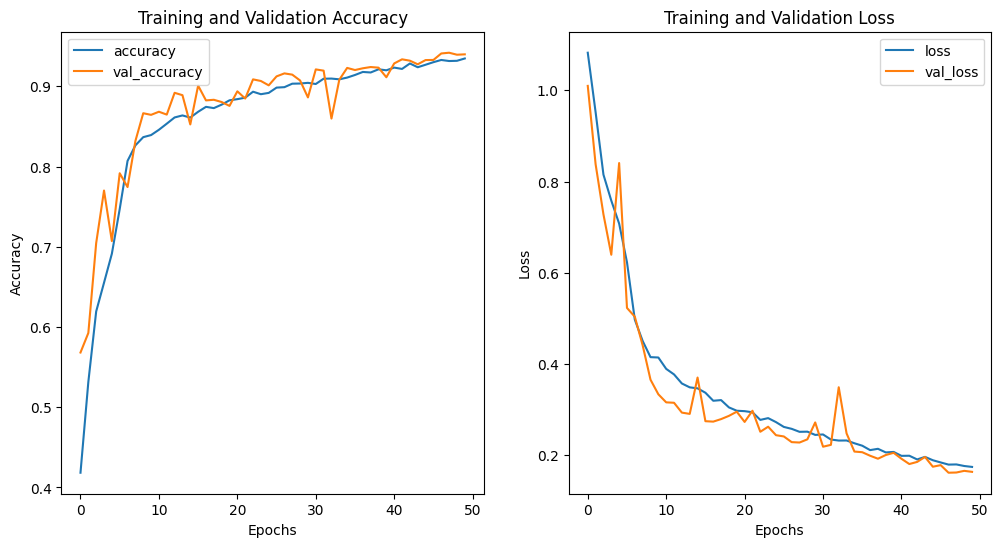

In [19]:
plot_history(history_6)

This model exhibits effective learning and good generalization with stable performance across all epochs, indicating reliability compared to previous models.

157/326 [=============>................] - ETA: 8s - loss: 0.2872 - accuracy: 0.8929

2024-07-05 22:34:08.445524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 16s 49ms/step - loss: 0.2162 - accuracy: 0.9193
Loss: 0.2162383645772934
Accuracy: 0.9192928671836853


160/326 [=============>................] - ETA: 7s

2024-07-05 22:34:24.532964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


326/326 [==============================] - 16s 49ms/step


2024-07-05 22:34:37.463253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3476
           1       0.86      0.93      0.89      3487
           2       0.95      0.86      0.90      3445

    accuracy                           0.92     10408
   macro avg       0.92      0.92      0.92     10408
weighted avg       0.92      0.92      0.92     10408



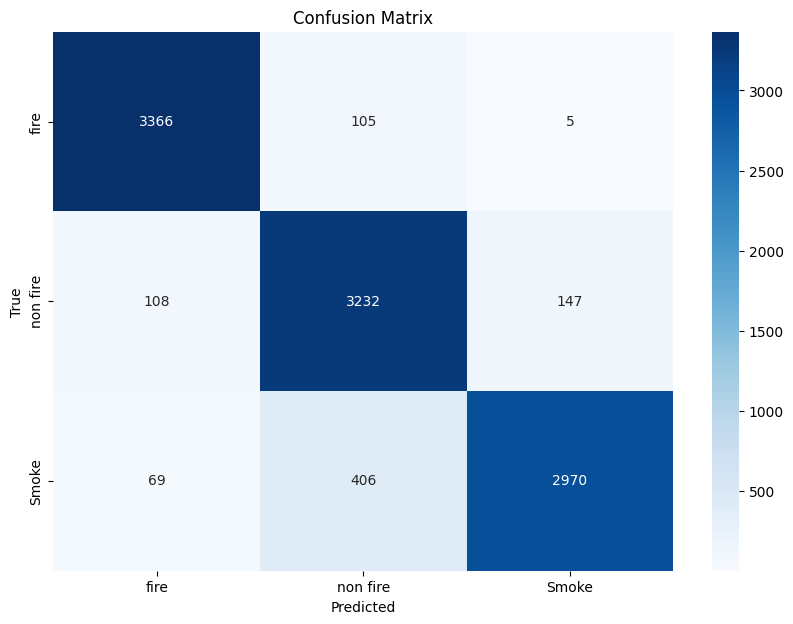

In [11]:
from tensorflow import keras

# Load the best model
best_model = keras.models.load_model('efficientnet_model.keras')

metrics(best_model, class_names, test_ds)

#### EfficientNetV2B0

In [12]:
from tensorflow.keras.applications import EfficientNetV2B0

# Load pre-trained EfficientNetB0 model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

24274472/24274472 [==============================] - 8s 0us/step


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# Add custom layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)  # Adjust the number of classes

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5923155 (22.60 MB)
Trainable params: 3843 (15.0

In [14]:
history_7 = model.fit(augmented_train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10


2024-07-15 14:10:06.626800: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-15 14:10:07.528561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/793 [..............................] - ETA: 16s - loss: 1.1116 - accuracy: 0.3516    

2024-07-15 14:10:07.920592: I external/local_xla/xla/service/service.cc:168] XLA service 0x71281946c3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-15 14:10:07.920609: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-15 14:10:07.923695: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721041807.972604  244885 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


118/793 [===>..........................] - ETA: 15s - loss: 1.1241 - accuracy: 0.3432

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 37s 41ms/step - loss: 1.1107 - accuracy: 0.3546 - val_loss: 1.0876 - val_accuracy: 0.3550
Epoch 2/10
 32/793 [>.............................] - ETA: 26s - loss: 1.0988 - accuracy: 0.3652

2024-07-15 14:10:42.235884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/793 [===>..........................] - ETA: 21s - loss: 1.0994 - accuracy: 0.3700

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 33s 41ms/step - loss: 1.0911 - accuracy: 0.3754 - val_loss: 1.0753 - val_accuracy: 0.3512
Epoch 3/10
 34/793 [>.............................] - ETA: 26s - loss: 1.0782 - accuracy: 0.3768

2024-07-15 14:11:15.426145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/793 [===>..........................] - ETA: 21s - loss: 1.0814 - accuracy: 0.3977

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 35s 43ms/step - loss: 1.0820 - accuracy: 0.3950 - val_loss: 1.0627 - val_accuracy: 0.4223
Epoch 4/10
 36/793 [>.............................] - ETA: 25s - loss: 1.0731 - accuracy: 0.4036

2024-07-15 14:11:50.223062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/793 [===>..........................] - ETA: 21s - loss: 1.0713 - accuracy: 0.4048

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 36s 45ms/step - loss: 1.0759 - accuracy: 0.4034 - val_loss: 1.0587 - val_accuracy: 0.4138
Epoch 5/10
 32/793 [>.............................] - ETA: 26s - loss: 1.0630 - accuracy: 0.4180

2024-07-15 14:12:26.406395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/793 [===>..........................] - ETA: 22s - loss: 1.0658 - accuracy: 0.4154

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 37s 46ms/step - loss: 1.0701 - accuracy: 0.4084 - val_loss: 1.0670 - val_accuracy: 0.3652
Epoch 6/10
 36/793 [>.............................] - ETA: 25s - loss: 1.0558 - accuracy: 0.4332

2024-07-15 14:13:02.976401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/793 [===>..........................] - ETA: 20s - loss: 1.0691 - accuracy: 0.4147

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 35s 44ms/step - loss: 1.0683 - accuracy: 0.4126 - val_loss: 1.0742 - val_accuracy: 0.4365
Epoch 7/10
 35/793 [>.............................] - ETA: 24s - loss: 1.0610 - accuracy: 0.4089

2024-07-15 14:13:38.147419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/793 [===>..........................] - ETA: 21s - loss: 1.0633 - accuracy: 0.4125

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 35s 44ms/step - loss: 1.0657 - accuracy: 0.4176 - val_loss: 1.0527 - val_accuracy: 0.4368
Epoch 8/10
 32/793 [>.............................] - ETA: 26s - loss: 1.0717 - accuracy: 0.4014

2024-07-15 14:14:13.533002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/793 [===>..........................] - ETA: 21s - loss: 1.0588 - accuracy: 0.4164

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 35s 44ms/step - loss: 1.0620 - accuracy: 0.4181 - val_loss: 1.0590 - val_accuracy: 0.3820
Epoch 9/10
 35/793 [>.............................] - ETA: 25s - loss: 1.0670 - accuracy: 0.4143

2024-07-15 14:14:48.644846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/793 [===>..........................] - ETA: 22s - loss: 1.0588 - accuracy: 0.4307

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 36s 45ms/step - loss: 1.0619 - accuracy: 0.4202 - val_loss: 1.0620 - val_accuracy: 0.3775
Epoch 10/10
 35/793 [>.............................] - ETA: 25s - loss: 1.0541 - accuracy: 0.4554

2024-07-15 14:15:24.717524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/793 [===>..........................] - ETA: 20s - loss: 1.0533 - accuracy: 0.4317

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - 35s 44ms/step - loss: 1.0604 - accuracy: 0.4247 - val_loss: 1.0655 - val_accuracy: 0.3329


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

my_callbacks = [

    ModelCheckpoint(
    'efficientnetv2_model.keras',
     save_best_only=True,
     monitor='val_loss',
     mode='min',
     verbose=2),

    EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=1,
    mode="auto")

]

Now unfreeze the model and continue training with lower LR

In [16]:
# Fine-tune the model
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history_8 = model.fit(augmented_train_ds, epochs=50, validation_data=validation_ds, callbacks=my_callbacks)

Epoch 1/50
 19/793 [..............................] - ETA: 31s - loss: 1.1908 - accuracy: 0.3701

2024-07-15 14:17:55.146599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/793 [===>..........................] - ETA: 30s - loss: 1.1095 - accuracy: 0.4077

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 1.0185 - accuracy: 0.4751
Epoch 1: val_loss improved from inf to 0.82370, saving model to efficientnetv2_model.keras
793/793 [==============================] - 68s 59ms/step - loss: 1.0185 - accuracy: 0.4751 - val_loss: 0.8237 - val_accuracy: 0.7174
Epoch 2/50
 13/793 [..............................] - ETA: 1:09 - loss: 0.9239 - accuracy: 0.5168

2024-07-15 14:18:42.816227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 38s - loss: 0.8752 - accuracy: 0.5783

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 0.7723 - accuracy: 0.6526
Epoch 2: val_loss improved from 0.82370 to 0.57354, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 54ms/step - loss: 0.7723 - accuracy: 0.6526 - val_loss: 0.5735 - val_accuracy: 0.7909
Epoch 3/50
 13/793 [..............................] - ETA: 1:11 - loss: 0.6482 - accuracy: 0.7356

2024-07-15 14:19:26.395832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/793 [==>...........................] - ETA: 37s - loss: 0.6839 - accuracy: 0.7035

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.7563
Epoch 3: val_loss improved from 0.57354 to 0.49192, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 55ms/step - loss: 0.5949 - accuracy: 0.7564 - val_loss: 0.4919 - val_accuracy: 0.8207
Epoch 4/50
 17/793 [..............................] - ETA: 59s - loss: 0.6510 - accuracy: 0.7298 

2024-07-15 14:20:10.427536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/793 [==>...........................] - ETA: 34s - loss: 0.5654 - accuracy: 0.7636

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.5035 - accuracy: 0.8024
Epoch 4: val_loss improved from 0.49192 to 0.45541, saving model to efficientnetv2_model.keras
793/793 [==============================] - 43s 54ms/step - loss: 0.5035 - accuracy: 0.8025 - val_loss: 0.4554 - val_accuracy: 0.8235
Epoch 5/50
 13/793 [..............................] - ETA: 1:10 - loss: 0.4411 - accuracy: 0.8077

2024-07-15 14:20:53.716845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/793 [==>...........................] - ETA: 37s - loss: 0.4728 - accuracy: 0.8135

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.4583 - accuracy: 0.8232
Epoch 5: val_loss improved from 0.45541 to 0.41188, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 55ms/step - loss: 0.4582 - accuracy: 0.8233 - val_loss: 0.4119 - val_accuracy: 0.8398
Epoch 6/50
 12/793 [..............................] - ETA: 1:16 - loss: 0.4076 - accuracy: 0.8724

2024-07-15 14:21:37.817843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.4358 - accuracy: 0.8235

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.4383 - accuracy: 0.8299
Epoch 6: val_loss did not improve from 0.41188
793/793 [==============================] - 43s 53ms/step - loss: 0.4383 - accuracy: 0.8300 - val_loss: 0.4680 - val_accuracy: 0.8196
Epoch 7/50
 12/793 [..............................] - ETA: 1:17 - loss: 0.4866 - accuracy: 0.8203

2024-07-15 14:22:20.512781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.4282 - accuracy: 0.8362

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.4186 - accuracy: 0.8401
Epoch 7: val_loss did not improve from 0.41188
793/793 [==============================] - 43s 53ms/step - loss: 0.4187 - accuracy: 0.8402 - val_loss: 0.4509 - val_accuracy: 0.8259
Epoch 8/50
 14/793 [..............................] - ETA: 1:04 - loss: 0.4405 - accuracy: 0.8348

2024-07-15 14:23:03.119451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/793 [==>...........................] - ETA: 35s - loss: 0.3974 - accuracy: 0.8484

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.4009 - accuracy: 0.8463
Epoch 8: val_loss improved from 0.41188 to 0.36179, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 55ms/step - loss: 0.4009 - accuracy: 0.8463 - val_loss: 0.3618 - val_accuracy: 0.8693
Epoch 9/50
 12/793 [..............................] - ETA: 1:14 - loss: 0.3792 - accuracy: 0.8620

2024-07-15 14:23:47.135976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/793 [==>...........................] - ETA: 37s - loss: 0.3906 - accuracy: 0.8475

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.3842 - accuracy: 0.8515
Epoch 9: val_loss improved from 0.36179 to 0.35120, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 54ms/step - loss: 0.3844 - accuracy: 0.8515 - val_loss: 0.3512 - val_accuracy: 0.8691
Epoch 10/50
 12/793 [..............................] - ETA: 1:19 - loss: 0.3707 - accuracy: 0.8516

2024-07-15 14:24:30.720896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 38s - loss: 0.3610 - accuracy: 0.8613

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8592
Epoch 10: val_loss improved from 0.35120 to 0.33395, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 55ms/step - loss: 0.3632 - accuracy: 0.8592 - val_loss: 0.3339 - val_accuracy: 0.8686
Epoch 11/50
 12/793 [..............................] - ETA: 1:18 - loss: 0.4628 - accuracy: 0.8229

2024-07-15 14:25:14.295950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/793 [==>...........................] - ETA: 38s - loss: 0.3758 - accuracy: 0.8584

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.3416 - accuracy: 0.8698
Epoch 11: val_loss improved from 0.33395 to 0.29833, saving model to efficientnetv2_model.keras
793/793 [==============================] - 43s 54ms/step - loss: 0.3415 - accuracy: 0.8698 - val_loss: 0.2983 - val_accuracy: 0.8816
Epoch 12/50
 13/793 [..............................] - ETA: 1:10 - loss: 0.3383 - accuracy: 0.8630

2024-07-15 14:25:57.666389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.3259 - accuracy: 0.8678

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.3306 - accuracy: 0.8716
Epoch 12: val_loss did not improve from 0.29833
793/793 [==============================] - 43s 54ms/step - loss: 0.3305 - accuracy: 0.8716 - val_loss: 0.3190 - val_accuracy: 0.8705
Epoch 13/50
 13/793 [..............................] - ETA: 1:09 - loss: 0.3696 - accuracy: 0.8582

2024-07-15 14:26:40.647132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/793 [==>...........................] - ETA: 36s - loss: 0.3322 - accuracy: 0.8706

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.3190 - accuracy: 0.8789
Epoch 13: val_loss improved from 0.29833 to 0.27346, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 55ms/step - loss: 0.3188 - accuracy: 0.8790 - val_loss: 0.2735 - val_accuracy: 0.9035
Epoch 14/50
 12/793 [..............................] - ETA: 1:16 - loss: 0.3104 - accuracy: 0.8724

2024-07-15 14:27:24.552753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 38s - loss: 0.3037 - accuracy: 0.8819

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.3011 - accuracy: 0.8847
Epoch 14: val_loss improved from 0.27346 to 0.25920, saving model to efficientnetv2_model.keras
793/793 [==============================] - 43s 54ms/step - loss: 0.3011 - accuracy: 0.8847 - val_loss: 0.2592 - val_accuracy: 0.9085
Epoch 15/50
 16/793 [..............................] - ETA: 1:01 - loss: 0.2706 - accuracy: 0.9004

2024-07-15 14:28:08.113828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/793 [==>...........................] - ETA: 35s - loss: 0.2962 - accuracy: 0.8833

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.8911
Epoch 15: val_loss did not improve from 0.25920
793/793 [==============================] - 43s 54ms/step - loss: 0.2854 - accuracy: 0.8911 - val_loss: 0.3452 - val_accuracy: 0.8669
Epoch 16/50
 12/793 [..............................] - ETA: 1:14 - loss: 0.3116 - accuracy: 0.8802

2024-07-15 14:28:51.162915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.3024 - accuracy: 0.8853

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.2737 - accuracy: 0.8966
Epoch 16: val_loss improved from 0.25920 to 0.24415, saving model to efficientnetv2_model.keras
793/793 [==============================] - 43s 54ms/step - loss: 0.2737 - accuracy: 0.8966 - val_loss: 0.2441 - val_accuracy: 0.9109
Epoch 17/50
 12/793 [..............................] - ETA: 1:14 - loss: 0.2891 - accuracy: 0.8620

2024-07-15 14:29:34.575428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.2721 - accuracy: 0.8839

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.9003
Epoch 17: val_loss did not improve from 0.24415
793/793 [==============================] - 43s 53ms/step - loss: 0.2629 - accuracy: 0.9003 - val_loss: 0.2535 - val_accuracy: 0.9150
Epoch 18/50
 12/793 [..............................] - ETA: 1:15 - loss: 0.2486 - accuracy: 0.9089

2024-07-15 14:30:17.305818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/793 [==>...........................] - ETA: 38s - loss: 0.2623 - accuracy: 0.8971

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.9089
Epoch 18: val_loss improved from 0.24415 to 0.22076, saving model to efficientnetv2_model.keras
793/793 [==============================] - 43s 54ms/step - loss: 0.2453 - accuracy: 0.9089 - val_loss: 0.2208 - val_accuracy: 0.9251
Epoch 19/50
 13/793 [..............................] - ETA: 1:08 - loss: 0.1894 - accuracy: 0.9351

2024-07-15 14:31:00.693529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.2317 - accuracy: 0.9117

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9130
Epoch 19: val_loss did not improve from 0.22076
793/793 [==============================] - 43s 54ms/step - loss: 0.2351 - accuracy: 0.9130 - val_loss: 0.2272 - val_accuracy: 0.9249
Epoch 20/50
 12/793 [..............................] - ETA: 1:17 - loss: 0.2243 - accuracy: 0.9141

2024-07-15 14:31:43.618278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 38s - loss: 0.2223 - accuracy: 0.9172

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.2279 - accuracy: 0.9177
Epoch 20: val_loss did not improve from 0.22076
793/793 [==============================] - 43s 54ms/step - loss: 0.2279 - accuracy: 0.9176 - val_loss: 0.2272 - val_accuracy: 0.9240
Epoch 21/50
 14/793 [..............................] - ETA: 1:10 - loss: 0.2530 - accuracy: 0.8973

2024-07-15 14:32:26.582903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/793 [==>...........................] - ETA: 37s - loss: 0.2159 - accuracy: 0.9243

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 0.2182 - accuracy: 0.9212
Epoch 21: val_loss improved from 0.22076 to 0.21240, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 55ms/step - loss: 0.2182 - accuracy: 0.9212 - val_loss: 0.2124 - val_accuracy: 0.9312
Epoch 22/50
 12/793 [..............................] - ETA: 1:11 - loss: 0.1384 - accuracy: 0.9557

2024-07-15 14:33:10.222358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 38s - loss: 0.1926 - accuracy: 0.9341

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.2020 - accuracy: 0.9269
Epoch 22: val_loss did not improve from 0.21240
793/793 [==============================] - 43s 53ms/step - loss: 0.2020 - accuracy: 0.9269 - val_loss: 0.2392 - val_accuracy: 0.9175
Epoch 23/50
 12/793 [..............................] - ETA: 1:15 - loss: 0.2214 - accuracy: 0.9062

2024-07-15 14:33:53.043676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.2073 - accuracy: 0.9248

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9315
Epoch 23: val_loss improved from 0.21240 to 0.18672, saving model to efficientnetv2_model.keras
793/793 [==============================] - 43s 54ms/step - loss: 0.1960 - accuracy: 0.9315 - val_loss: 0.1867 - val_accuracy: 0.9355
Epoch 24/50
 12/793 [..............................] - ETA: 1:11 - loss: 0.1464 - accuracy: 0.9505

2024-07-15 14:34:36.209916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 38s - loss: 0.1899 - accuracy: 0.9330

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 0.1929 - accuracy: 0.9327
Epoch 24: val_loss improved from 0.18672 to 0.16152, saving model to efficientnetv2_model.keras
793/793 [==============================] - 44s 55ms/step - loss: 0.1929 - accuracy: 0.9327 - val_loss: 0.1615 - val_accuracy: 0.9465
Epoch 25/50
 10/793 [..............................] - ETA: 1:21 - loss: 0.1023 - accuracy: 0.9656

2024-07-15 14:35:20.131480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/793 [==>...........................] - ETA: 38s - loss: 0.1760 - accuracy: 0.9350

Invalid SOS parameters for sequential JPEG


793/793 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9372
Epoch 25: val_loss did not improve from 0.16152
793/793 [==============================] - 43s 54ms/step - loss: 0.1798 - accuracy: 0.9372 - val_loss: 0.1816 - val_accuracy: 0.9399
Epoch 26/50
 13/793 [..............................] - ETA: 1:08 - loss: 0.1728 - accuracy: 0.9351

2024-07-15 14:36:03.100786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 38s - loss: 0.1736 - accuracy: 0.9427

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.1748 - accuracy: 0.9400
Epoch 26: val_loss did not improve from 0.16152
793/793 [==============================] - 43s 54ms/step - loss: 0.1751 - accuracy: 0.9399 - val_loss: 0.1668 - val_accuracy: 0.9453
Epoch 27/50
 11/793 [..............................] - ETA: 1:11 - loss: 0.1342 - accuracy: 0.9574

2024-07-15 14:36:45.934971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/793 [==>...........................] - ETA: 37s - loss: 0.1722 - accuracy: 0.9409

Invalid SOS parameters for sequential JPEG


792/793 [============================>.] - ETA: 0s - loss: 0.1695 - accuracy: 0.9411
Epoch 27: val_loss did not improve from 0.16152
793/793 [==============================] - 43s 54ms/step - loss: 0.1695 - accuracy: 0.9411 - val_loss: 0.1620 - val_accuracy: 0.9484
Epoch 27: early stopping


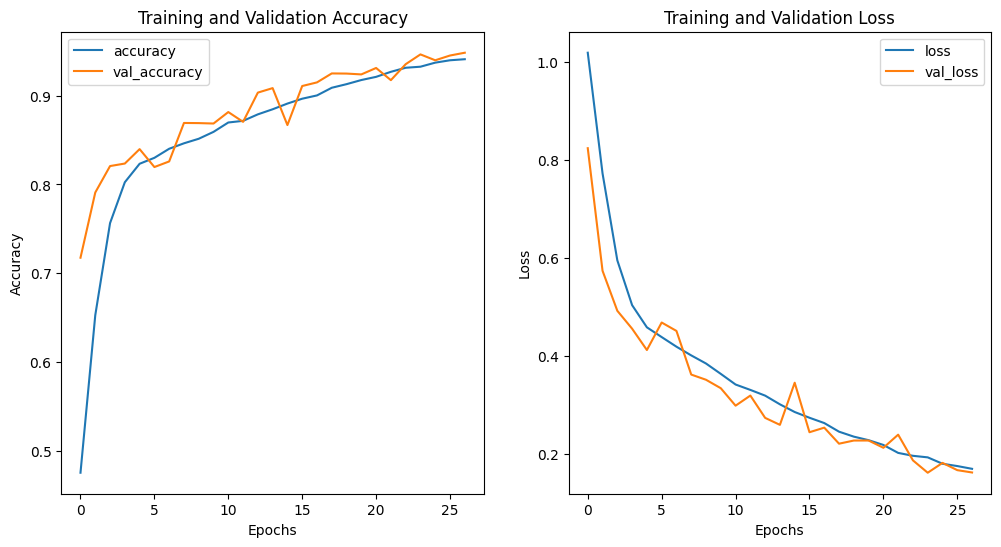

In [17]:
plot_history(history_8)

EfficientNetV2 performed poorly compared to the previous EfficientNet model. Since I kept all hyperparameters the same, in sake of making a fair comparison, we can safely assume that increasing the parameters (5.3M -> 7.2M) did not improve the performace. 

141/294 [=============>................] - ETA: 3s - loss: 0.1861 - accuracy: 0.9328

2024-07-15 14:49:16.561601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


294/294 [==============================] - 9s 26ms/step - loss: 0.1650 - accuracy: 0.9438
Loss: 0.16501525044441223
Accuracy: 0.9437652826309204


141/294 [=============>................] - ETA: 3s

2024-07-15 14:49:24.822564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


294/294 [==============================] - 8s 26ms/step


2024-07-15 14:49:32.324974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3478
           1       0.92      0.94      0.93      3487
           2       0.97      0.91      0.94      2442

    accuracy                           0.94      9407
   macro avg       0.95      0.94      0.94      9407
weighted avg       0.94      0.94      0.94      9407



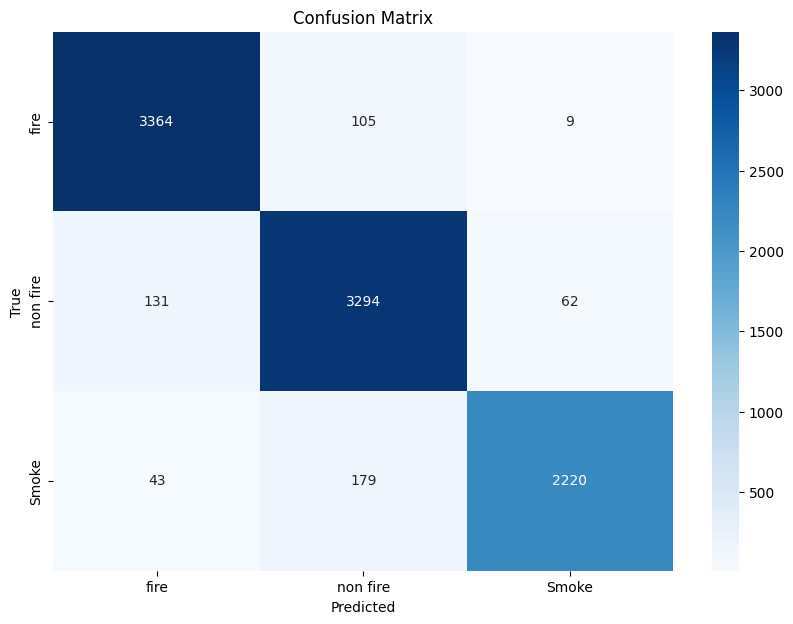

In [22]:
from tensorflow import keras

# Load the best model
best_model = keras.models.load_model('efficientnetv2_model.keras')

metrics(best_model, class_names, test_ds)

## Conclusion and future improvements

Although our pre-trained models had more stable performance did not outperform our 4th custom model in terms of generalization. Increasing parameters on a relatively small dataset, can cause overfitting, that's why our more lightweight model generalized better than the pre-trained ones.

In the future we could put to test other types of convolutional layers like `SeparableConv2D` and `DepthwiseConv2D` to improve out custom models. Furthermore, we could also test more lightweight models like `MobileNetV2`.